<a href="https://colab.research.google.com/github/christiandoramo/IA-PROJ-1-NN-SRM/blob/main/%5BPROJ_1VA%5D_NN_SRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [PROJ-1VA] - NNSRM
######  SEMESTRE: 2024.1
######  DATA: 01/08/2024
######  DISCIPLINA: INTELIGÊNCIA ARTIFICIAL
######  CURSO: CIÊNCIA DA COMPUTAÇÃO
######  DOCENTE: GEORGE GOMES CABRAL
######  DISCENTE: CHRISTIAN OLIVEIRA DO RAMO
######  MATRÍCULA: 200737470

Requisitos/Recomendações:

Bases de dados:

Datasets:

https://archive.ics.uci.edu/dataset/42/glass+identification

https://archive.ics.uci.edu/dataset/53/iris

Os dados devem ser divididos em 66% para treinamento e o restante para teste.

slide: https://docs.google.com/presentation/d/1BkAPzKx7WqeawuLTNzdvB3YncV3isp2Egov6fN2KGLk/edit?usp=sharing

In [ ]:
!pip install ucimlrepo

## Importando bibliotecas

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from sklearn.preprocessing import LabelEncoder
import matplotlib.colors as mcolors
from ucimlrepo import fetch_ucirepo
from sklearn.datasets import fetch_openml

## gerando dados toy

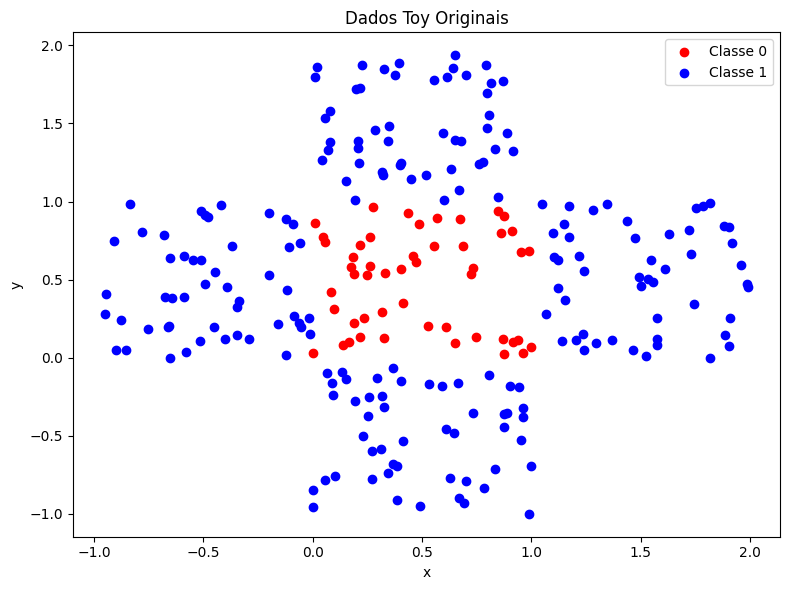

In [ ]:
def gerar_dados(quantidade_por_quadrante):
  x0_0 = np.random.uniform(0,1,quantidade_por_quadrante)
  x0_1 = np.random.uniform(0,1,quantidade_por_quadrante)
  # print(x0_0)
  #lado direito
  x_0 = np.random.uniform(1,2,quantidade_por_quadrante)
  y_0 = np.random.uniform(0,1,quantidade_por_quadrante)

  #lado esquerdo
  x_1 = np.random.uniform(-1,0,quantidade_por_quadrante)
  y_1 = np.random.uniform(0,1, quantidade_por_quadrante)

  #cima
  x_2 = np.random.uniform(0,1,quantidade_por_quadrante)
  y_2 = np.random.uniform(1,2,quantidade_por_quadrante)


  #baixo
  x_3 = np.random.uniform(0,1,quantidade_por_quadrante)
  y_3 = np.random.uniform(-1,0,quantidade_por_quadrante)

  a_0 = []
  a_1 = []

  b_0 = []
  b_1 = []

  for i in range(quantidade_por_quadrante):

      a_0.append(x0_0[i])
      a_1.append(x0_1[i])

      b_0.append(x_0[i])
      b_0.append(x_1[i])
      b_0.append(x_2[i])
      b_0.append(x_3[i])

      b_1.append(y_0[i])
      b_1.append(y_1[i])
      b_1.append(y_2[i])
      b_1.append(y_3[i])

  X_toy = np.vstack((np.column_stack((a_0, a_1)), np.column_stack((b_0, b_1)))) # combina a_0 com a_1,b_0 com b_1 formando um coluna de pontos [x,y] e depois junta a e b em uma coluna só como um conjunto de features [x,y]
  y_toy = np.array([0] * len(a_0) + [1] * len(b_0))  #  conjunto de classes relacionada a X_toy no caso a=0, b=1
  return X_toy, y_toy

X_toy, y_toy =gerar_dados(50)

# Plotando os dados originais
plt.figure(figsize=(8, 6))
plt.scatter(X_toy[y_toy == 0][:, 0], X_toy[y_toy == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy[y_toy == 1][:, 0], X_toy[y_toy == 1][:, 1], color='blue', label='Classe 1')
plt.title("Dados Toy Originais")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

plt.show()

## Algoritmo NNSRM + classificação com conjunto S e plot de dados originais com predição dentro do treino

numero de distancias entre classes: 10000


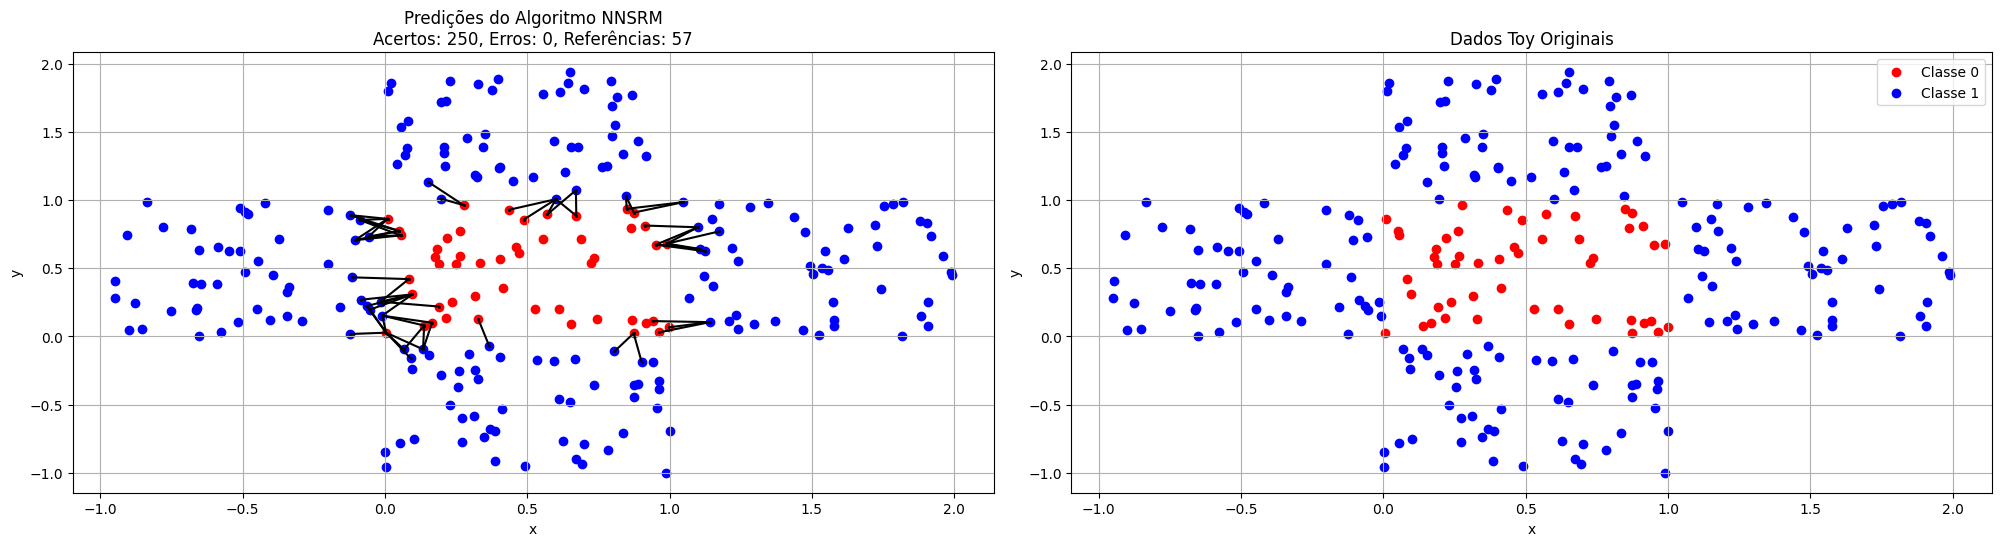

In [ ]:
def classificar_com_referencias(xi, conjunto_referencias, conjunto_treinamento, distancia_memo):
    if not conjunto_referencias:
        return 1

    pontos_para_classes = {tuple(xt): yt for xt, yt in conjunto_treinamento}
    xi_tupla = tuple(xi)  #xi para tupla

    distancias = []
    for xr1, xr2 in conjunto_referencias:
        xr1_tupla = tuple(xr1)
        xr2_tupla = tuple(xr2)

        if (xi_tupla, xr1_tupla) in distancia_memo:
            distancia1 = distancia_memo[(xi_tupla, xr1_tupla)]
        else:
            distancia1 = distance.euclidean(xi,xr1)
            distancia_memo[(xi_tupla, xr1_tupla)] = distancia1

        if (xi_tupla, xr2_tupla) in distancia_memo:
            distancia2 = distancia_memo[(xi_tupla, xr2_tupla)]
        else:
            distancia2 = distance.euclidean(xi,xr2)
            distancia_memo[(xi_tupla, xr2_tupla)] = distancia2

        distancias.append((pontos_para_classes[xr1_tupla], distancia1))
        distancias.append((pontos_para_classes[xr2_tupla], distancia2))

    return min(distancias, key=lambda par: par[1])[0]

def calcular_erro_empirico(conjunto_treinamento, conjunto_referencias):
    erro = 0
    distancia_memo = {}

    for xi, yi in conjunto_treinamento:
        classe_predita = classificar_com_referencias(xi, conjunto_referencias, conjunto_treinamento, distancia_memo)
        if classe_predita != yi:
            erro += 1

    return erro

def calcular_distancias_entre_classes(conjunto_treinamento):
    distancias = set()  # Usar um set para evitar duplicação

    for i, (xi, yi) in enumerate(conjunto_treinamento):
        for j, (xj, yj) in enumerate(conjunto_treinamento):
            if i >= j:  # não repete contas de pontos repetidos
                continue
            if yi != yj and not np.array_equal(xi, xj):  # checar se são de classes diferentes e não iguais
                distancia = distance.euclidean(xi,xj)
                par_referencia_ordenado = tuple(sorted((tuple(xi), tuple(xj))))
                distancias.add((par_referencia_ordenado, distancia))
    distancias = sorted(distancias, key=lambda par: par[1])
    return [par[0] for par in distancias]

def nn_srm(conjunto_treinamento):
    conjunto_referencias = set()  # Conjunto S
    distancias = calcular_distancias_entre_classes(conjunto_treinamento)
    erro_empirico = calcular_erro_empirico(conjunto_treinamento, conjunto_referencias)

    if erro_empirico == 0:
        return conjunto_referencias

    print(f"numero de distancias entre classes: {len(distancias)}")

    for k, (xi, xj) in enumerate(distancias):
        par_referencia_ordenado = tuple(sorted((tuple(xi), tuple(xj))))

        if par_referencia_ordenado not in conjunto_referencias:
            conjunto_referencias.add(par_referencia_ordenado)
            erro_empirico = calcular_erro_empirico(conjunto_treinamento, conjunto_referencias)

        if erro_empirico == 0:
            break

    return conjunto_referencias

dados_classe_1 = X_toy[y_toy == 0]
dados_classe_2 = X_toy[y_toy == 1]

conjunto_treinamento = [(xi, 0) for xi in dados_classe_1] + [(xi, 1) for xi in dados_classe_2]

# retornando S pelo algoritmo NNSRM
conjunto_referencias = nn_srm(conjunto_treinamento)

total_pontos_classe_1 = len(dados_classe_1)
total_pontos_classe_2 = len(dados_classe_2)

predicoes = np.array([classificar_com_referencias(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_toy])

total_acertos = 0
total_erros = 0
for i, (x, y) in enumerate(X_toy):
    cor = 'black' if y_toy[i] == predicoes[i] else 'red'
    if y_toy[i] == predicoes[i]:
        total_acertos += 1
    else:
        total_erros += 1

total_referencias = len(conjunto_referencias)
plt.figure(figsize=(100, 50))

plt.subplot(10, 10,1)
plt.title(f"Predições do Algoritmo NNSRM\nAcertos: {total_acertos}, Erros: {total_erros}, Referências: {total_referencias}")


plt.scatter(X_toy[predicoes == 0][:, 0], X_toy[predicoes == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy[predicoes == 1][:, 0], X_toy[predicoes == 1][:, 1], color='blue', label='Classe 1')

for xr1, xr2 in conjunto_referencias:
    plt.plot([xr1[0], xr2[0]], [xr1[1], xr2[1]], 'ko-', markersize=1)


plt.tight_layout()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)


plt.subplot(10,10,2)
plt.scatter(X_toy[y_toy == 0][:, 0], X_toy[y_toy == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy[y_toy == 1][:, 0], X_toy[y_toy == 1][:, 1], color='blue', label='Classe 1')
plt.title("Dados Toy Originais")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Testando predições com 66% dos dados como treino e o restante como teste para 2 classes

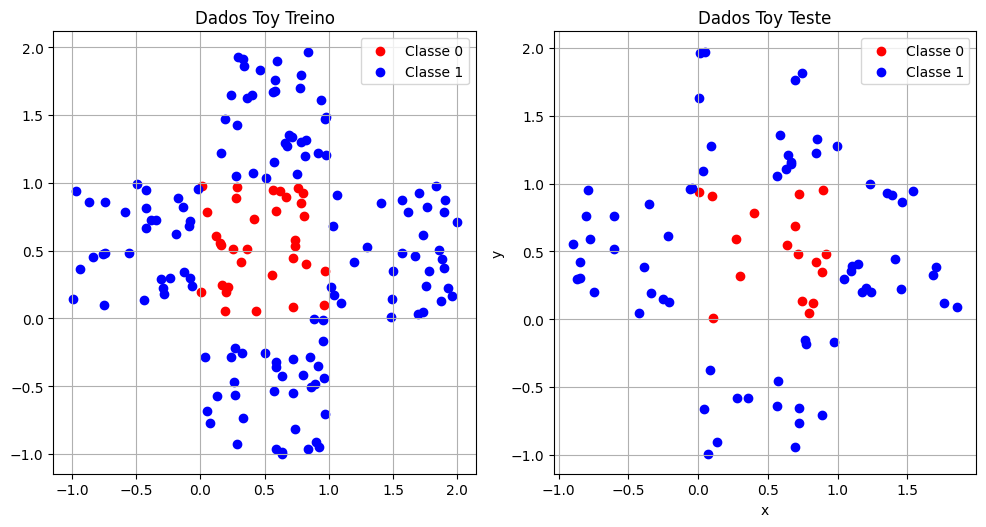

In [ ]:
X_toy, y_toy = gerar_dados(50)


X_toy_treino, X_toy_teste, y_toy_treino, y_toy_teste = train_test_split( # stratify = seguindo y_toy, para manter treino e teste mais equilibrados para não perder a efeitivadade do nnsrm
    X_toy, y_toy, train_size=0.66, stratify=y_toy) # 66% como treino e o restante como teste


plt.figure(figsize=(50, 50))
plt.subplot(10,10,1)
plt.scatter(X_toy_treino[y_toy_treino == 0][:, 0], X_toy_treino[y_toy_treino == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy_treino[y_toy_treino == 1][:, 0], X_toy_treino[y_toy_treino == 1][:, 1], color='blue', label='Classe 1')
plt.title("Dados Toy Treino")
plt.legend()
plt.grid(True)

plt.subplot(10,10,2)
plt.scatter(X_toy_teste[y_toy_teste == 0][:, 0], X_toy_teste[y_toy_teste == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy_teste[y_toy_teste == 1][:, 0], X_toy_teste[y_toy_teste == 1][:, 1], color='blue', label='Classe 1')
plt.title("Dados Toy Teste")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.tight_layout()

plt.show()

Plot previsões NNSRM para dados de teste X dados de teste toy

numero de distancias entre classes: 4356


<ipython-input-8-891313ed0374>:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(10,10, 1)


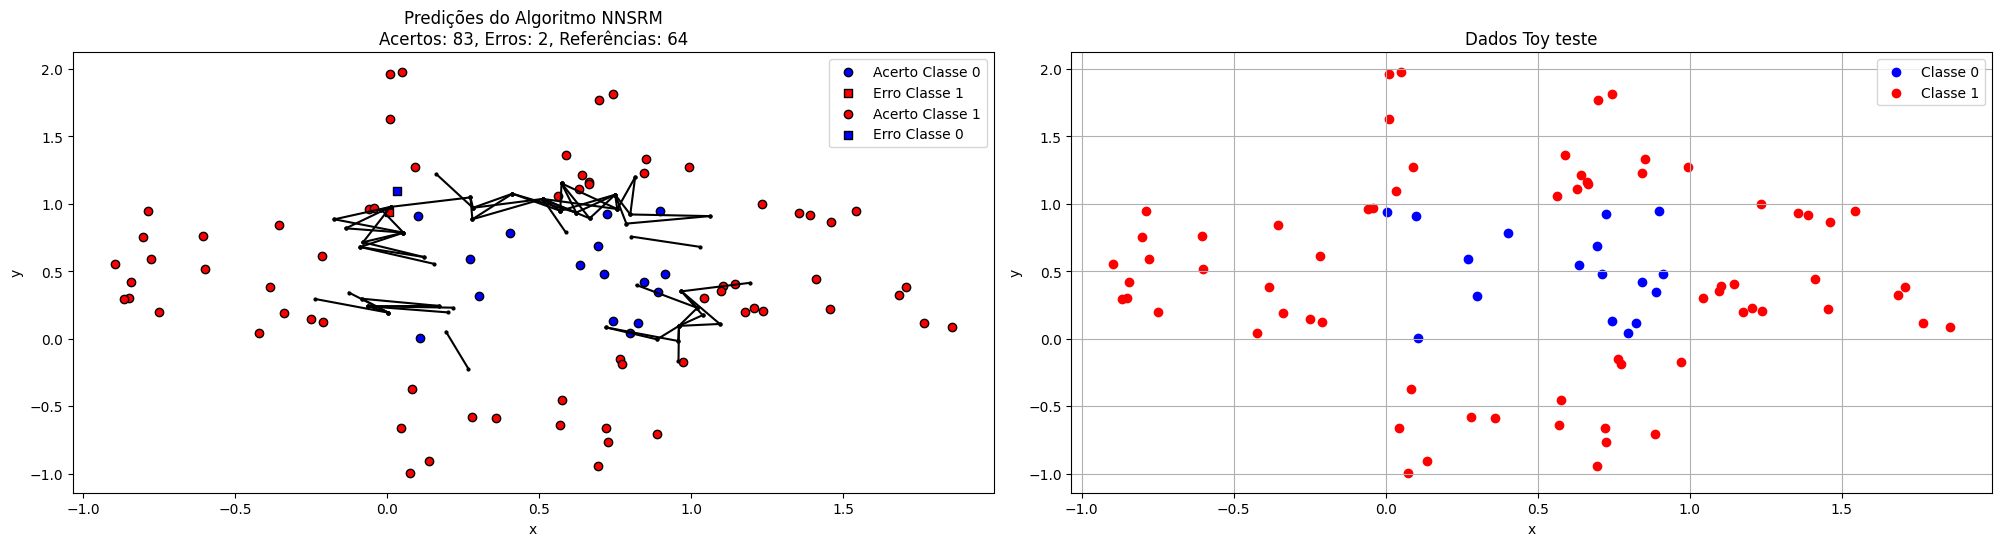

In [ ]:
dados_classe_1 = X_toy_treino[y_toy_treino == 0]
dados_classe_2 = X_toy_treino[y_toy_treino == 1]

conjunto_treinamento = [(xi, 0) for xi in dados_classe_1] + [(xi, 1) for xi in dados_classe_2]

teste_dados_classe_1 = X_toy_teste[y_toy_teste == 0]
teste_dados_classe_2 = X_toy_teste[y_toy_teste == 1]

conjunto_testes = [(xi, 0) for xi in teste_dados_classe_1] + [(xi, 1) for xi in teste_dados_classe_2]

conjunto_referencias = nn_srm(conjunto_treinamento)
##############
predicoes = np.array([classificar_com_referencias(xi, conjunto_referencias, conjunto_treinamento,{}) for (xi,yi) in conjunto_testes])

total_acertos = 0
total_erros = 0
for i, (xi, yi) in enumerate(conjunto_testes):
    if yi == predicoes[i]:
        total_acertos += 1
    else:
        total_erros += 1

total_referencias = len(conjunto_referencias)
plt.figure(figsize=(100, 50))



for xr1, xr2 in conjunto_referencias:
    plt.plot([xr1[0], xr2[0]], [xr1[1], xr2[1]], 'ko-', markersize=1)
###############################

cores = {0: 'blue', 1: 'red'}

#plot dos acertos
plt.subplot(10,10, 1)

for i,(xi, yi) in enumerate(conjunto_testes):
    if predicoes[i] == yi:
        plt.scatter(xi[0], xi[1], c=cores[predicoes[i]], marker='o', label=f'Acerto Classe {predicoes[i]}', edgecolor='black')
    else:
        plt.scatter(xi[0], xi[1], c=cores[predicoes[i]], marker='s', label=f'Erro Classe {predicoes[i]}', edgecolor='black')

plt.title(f"Predições do Algoritmo NNSRM\nAcertos: {total_acertos}, Erros: {total_erros}, Referências: {total_referencias}")

for xr1, xr2 in conjunto_referencias:
    plt.plot([xr1[0], xr2[0]], [xr1[1], xr2[1]], 'ko-', markersize=2)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("x")
plt.ylabel("y")

plt.subplot(10,10,2)

plt.scatter(X_toy_teste[y_toy_teste == 0][:, 0], X_toy_teste[y_toy_teste == 0][:, 1], color='blue', label='Classe 0')
plt.scatter(X_toy_teste[y_toy_teste == 1][:, 0], X_toy_teste[y_toy_teste == 1][:, 1], color='red', label='Classe 1')
plt.title("Dados Toy teste")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.tight_layout()
plt.show()

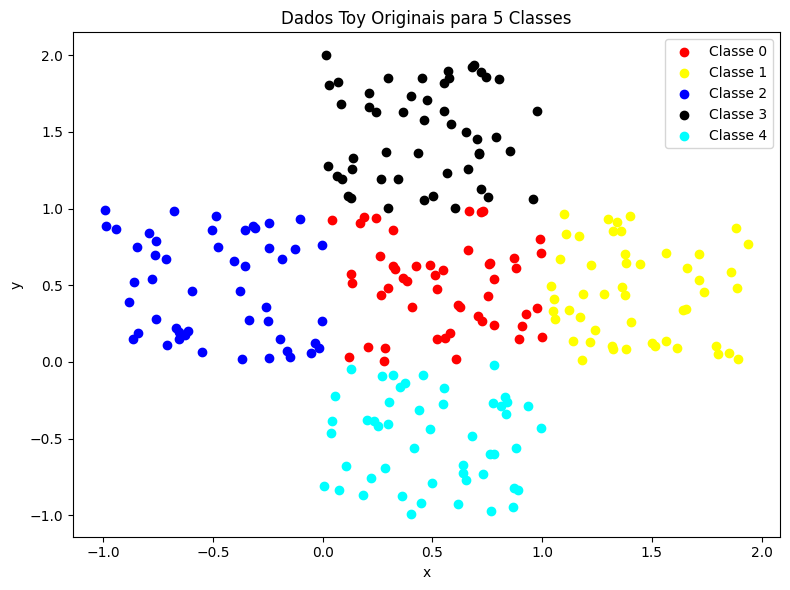

In [ ]:
def gerar_dados_5_classes(quantidade):
    # Classe 0 - Centro
    x0_0 = np.random.uniform(0, 1, quantidade)
    y0_1 = np.random.uniform(0, 1, quantidade)

    # Classe 1 - Direita
    x_0 = np.random.uniform(1, 2, quantidade)
    y_0 = np.random.uniform(0, 1, quantidade)

    # Classe 2 - Esquerda
    x_1 = np.random.uniform(-1, 0, quantidade)
    y_1 = np.random.uniform(0, 1, quantidade)

    # Classe 3 - Cima
    x_2 = np.random.uniform(0, 1, quantidade)
    y_2 = np.random.uniform(1, 2, quantidade)

    # Classe 4 - Baixo
    x_3 = np.random.uniform(0, 1, quantidade)
    y_3 = np.random.uniform(-1, 0, quantidade)

    X_toy = np.vstack((
        np.column_stack((x0_0, y0_1)),
        np.column_stack((x_0, y_0)),
        np.column_stack((x_1, y_1)),
        np.column_stack((x_2, y_2)),
        np.column_stack((x_3, y_3))
    ))

    y_toy = np.array(
        [0] * quantidade +
        [1] * quantidade +
        [2] * quantidade +
        [3] * quantidade +
        [4] * quantidade
    )

    return X_toy, y_toy

# adaptando para 5 classes
X_toy, y_toy = gerar_dados_5_classes(50)

plt.figure(figsize=(8, 6))
plt.scatter(X_toy[y_toy == 0][:, 0], X_toy[y_toy == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy[y_toy == 1][:, 0], X_toy[y_toy == 1][:, 1], color='yellow', label='Classe 1')
plt.scatter(X_toy[y_toy == 2][:, 0], X_toy[y_toy == 2][:, 1], color='blue', label='Classe 2')
plt.scatter(X_toy[y_toy == 3][:, 0], X_toy[y_toy == 3][:, 1], color='black', label='Classe 3')
plt.scatter(X_toy[y_toy == 4][:, 0], X_toy[y_toy == 4][:, 1], color='cyan', label='Classe 4')
plt.title("Dados Toy Originais para 5 Classes")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()

plt.show()

conjunto de treinamento aqui é o próprio conjunto toy - logo o NNSRM deve acertar previsões para os próimos 100% de pontos dele a partir do conjunto S

Distâncias calculadas entre classes: 25000


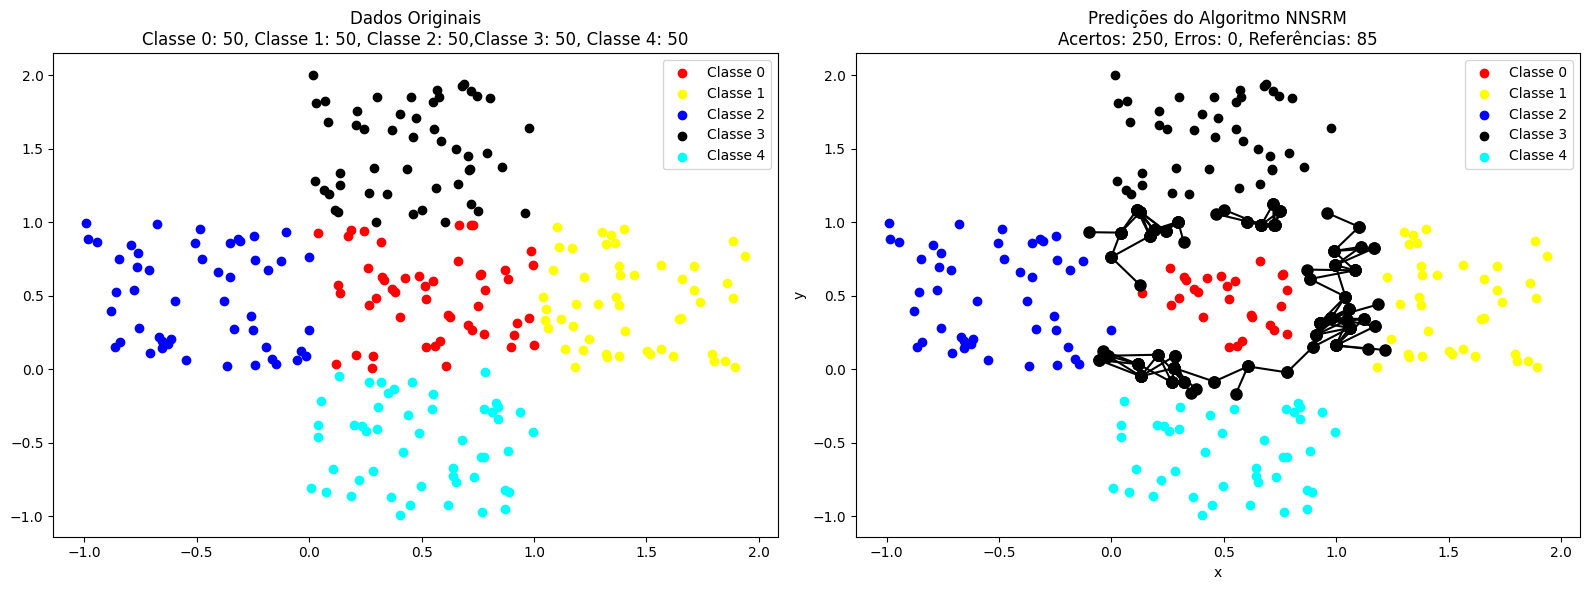

In [ ]:
def calcular_distancias_entre_classes_multiplas(conjunto_treinamento):
    distancias = []
    num_amostras = len(conjunto_treinamento)

    for i in range(num_amostras):
        xi, yi = conjunto_treinamento[i]
        for j in range(i + 1, num_amostras):
            if i >= j:  # não repete contas de pontos repetidos
              continue
            xj, yj = conjunto_treinamento[j]

            if yi != yj and not np.array_equal(xi, xj):
                distancia = np.linalg.norm(xi - xj)
                distancias.append(((xi, xj), distancia, yi, yj))
    distancias.sort(key=lambda par: par[1])
    return distancias


def classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento, distancia_memo):
    distancias = []
    pontos_para_classes = {tuple(xt): yt for xt, yt in conjunto_treinamento}

    xi_tupla = tuple(xi)  # Convertendo xi para tupla
    for xr1, xr2 in conjunto_referencias:
        xr1_tupla = tuple(xr1)
        xr2_tupla = tuple(xr2)

        if (xi_tupla, xr1_tupla) in distancia_memo:
            distancia1 = distancia_memo[(xi_tupla, xr1_tupla)]
        else:
            distancia1 = distance.euclidean(xi,xr1)
            distancia_memo[(xi_tupla, xr1_tupla)] = distancia1

        if (xi_tupla, xr2_tupla) in distancia_memo:
            distancia2 = distancia_memo[(xi_tupla, xr2_tupla)]
        else:
            distancia2 = distance.euclidean(xi,xr2)
            distancia_memo[(xi_tupla, xr2_tupla)] = distancia2

        distancias.append((pontos_para_classes[xr1_tupla], distancia1))
        distancias.append((pontos_para_classes[xr2_tupla], distancia2))

    if distancias:
        return min(distancias, key=lambda par: par[1])[0]
    else:
        return list(pontos_para_classes.values())[0]

def calcular_erro_empirico_multiclasse(conjunto_treinamento, conjunto_referencias):
    erro = 0
    distancia_memo = {}

    for xi, yi in conjunto_treinamento:
        classe_predita = classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento, distancia_memo)
        if classe_predita != yi:
            erro += 1

    return erro

def nn_srm_multiclasse(conjunto_treinamento):
    conjunto_referencias = set()  # Conjunto S
    distancias = calcular_distancias_entre_classes_multiplas(conjunto_treinamento)
    erro_empirico = calcular_erro_empirico_multiclasse(conjunto_treinamento, conjunto_referencias)

    # Verificação inicial do erro empírico
    if erro_empirico == 0:
        return conjunto_referencias

    print(f"distâncias calculadas entre classes: {len(distancias)}")

    for k, ((xr1, xr2), dist, yi, yj) in enumerate(distancias):
        xr1_tupla = tuple(xr1)
        xr2_tupla = tuple(xr2)

        par_ordenado = tuple(sorted((xr1_tupla, xr2_tupla)))

        if par_ordenado not in conjunto_referencias and yi != yj:
            conjunto_referencias.add(par_ordenado)
            erro_empirico = calcular_erro_empirico_multiclasse(conjunto_treinamento, conjunto_referencias)

        if erro_empirico == 0:
            break

    return conjunto_referencias

conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_toy, y_toy)]

conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)

predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_toy])

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)

num_classe_0 = sum(y_toy == 0)
num_classe_1 = sum(y_toy == 1)
num_classe_2 = sum(y_toy == 2)
num_classe_3 = sum(y_toy == 3)
num_classe_4 = sum(y_toy == 4)

plt.title(f"Dados Originais\nClasse 0: {num_classe_0}, Classe 1: {num_classe_1}, Classe 2: {num_classe_2},Classe 3: {num_classe_3}, Classe 4: {num_classe_4}")
plt.scatter(X_toy[y_toy == 0][:, 0], X_toy[y_toy == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy[y_toy == 1][:, 0], X_toy[y_toy == 1][:, 1], color='yellow', label='Classe 1')
plt.scatter(X_toy[y_toy == 2][:, 0], X_toy[y_toy == 2][:, 1], color='blue', label='Classe 2')
plt.scatter(X_toy[y_toy == 3][:, 0], X_toy[y_toy == 3][:, 1], color='black', label='Classe 3')
plt.scatter(X_toy[y_toy == 4][:, 0], X_toy[y_toy == 4][:, 1], color='cyan', label='Classe 4')
plt.legend()

plt.subplot(1, 2, 2)
acertos = 0
erros = 0
for i, (x, y) in enumerate(X_toy):
    cor = 'black' if y_toy[i] == predicoes[i] else 'red'
    if y_toy[i] == predicoes[i]:
        acertos += 1
    else:
        erros += 1
    # plt.text(x, y, str(predicoes[i]), fontsize=20, ha='center', va='center', color=cor)

plt.scatter(X_toy[predicoes == 0][:, 0], X_toy[predicoes == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy[predicoes == 1][:, 0], X_toy[predicoes == 1][:, 1], color='yellow', label='Classe 1')
plt.scatter(X_toy[predicoes == 2][:, 0], X_toy[predicoes == 2][:, 1], color='blue', label='Classe 2')
plt.scatter(X_toy[predicoes == 3][:, 0], X_toy[predicoes == 3][:, 1], color='black', label='Classe 3')
plt.scatter(X_toy[predicoes == 4][:, 0], X_toy[predicoes == 4][:, 1], color='cyan', label='Classe 4')

for xr1, xr2 in conjunto_referencias:
    plt.plot([xr1[0], xr2[0]], [xr1[1], xr2[1]], 'ko-', markersize=8)

plt.title(f"Predições do Algoritmo NNSRM\nAcertos: {acertos}, Erros: {erros}, Referências: {len(conjunto_referencias)}")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.show()

Testando predições com 66% dos dados como treino e o restande como teste para multiplas classes

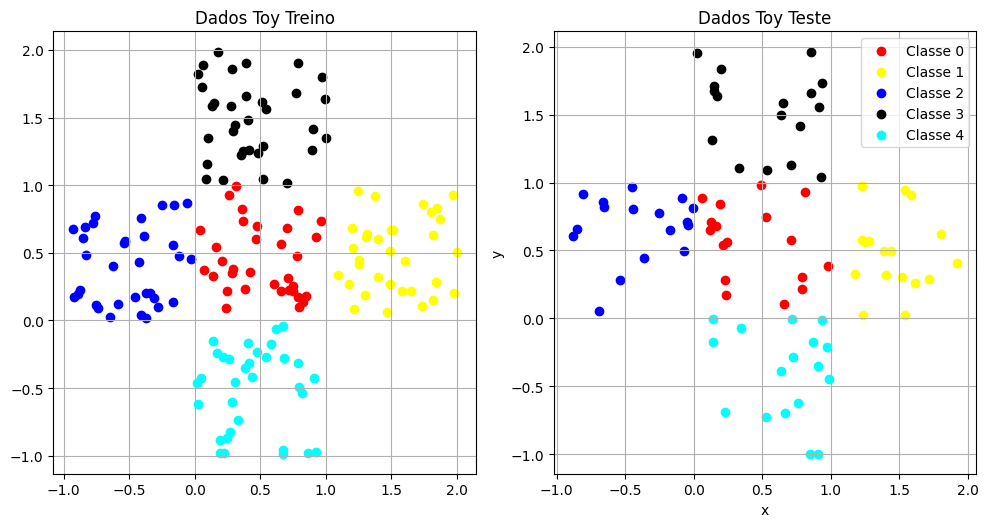

In [ ]:
X_toy, y_toy = gerar_dados_5_classes(50) # = 40 pontos, 8 de cada classe (66% é em torno de 27/28 pontos)

X_toy_treino, X_toy_teste, y_toy_treino, y_toy_teste = train_test_split( # stratify = seguindo y_toy, para manter treino e teste mais equilibrados para não perder a efeitivadade do nnsrm
    X_toy, y_toy, train_size=0.66, stratify=y_toy) # 66% como treino e o restante como teste


plt.figure(figsize=(50, 50))
plt.subplot(10,10,1)
plt.scatter(X_toy_treino[y_toy_treino == 0][:, 0], X_toy_treino[y_toy_treino == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy_treino[y_toy_treino == 1][:, 0], X_toy_treino[y_toy_treino == 1][:, 1], color='yellow', label='Classe 1')
plt.scatter(X_toy_treino[y_toy_treino == 2][:, 0], X_toy_treino[y_toy_treino == 2][:, 1], color='blue', label='Classe 2')
plt.scatter(X_toy_treino[y_toy_treino == 3][:, 0], X_toy_treino[y_toy_treino == 3][:, 1], color='black', label='Classe 3')
plt.scatter(X_toy_treino[y_toy_treino == 4][:, 0], X_toy_treino[y_toy_treino == 4][:, 1], color='cyan', label='Classe 4')
plt.title("Dados Toy Treino")
plt.grid(True)

plt.subplot(10,10,2)
plt.scatter(X_toy_teste[y_toy_teste == 0][:, 0], X_toy_teste[y_toy_teste == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy_teste[y_toy_teste == 1][:, 0], X_toy_teste[y_toy_teste == 1][:, 1], color='yellow', label='Classe 1')
plt.scatter(X_toy_teste[y_toy_teste == 2][:, 0], X_toy_teste[y_toy_teste == 2][:, 1], color='blue', label='Classe 2')
plt.scatter(X_toy_teste[y_toy_teste == 3][:, 0], X_toy_teste[y_toy_teste == 3][:, 1], color='black', label='Classe 3')
plt.scatter(X_toy_teste[y_toy_teste == 4][:, 0], X_toy_teste[y_toy_teste == 4][:, 1], color='cyan', label='Classe 4')
plt.title("Dados Toy Teste")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

plt.show()

Distâncias calculadas entre classes: 10890


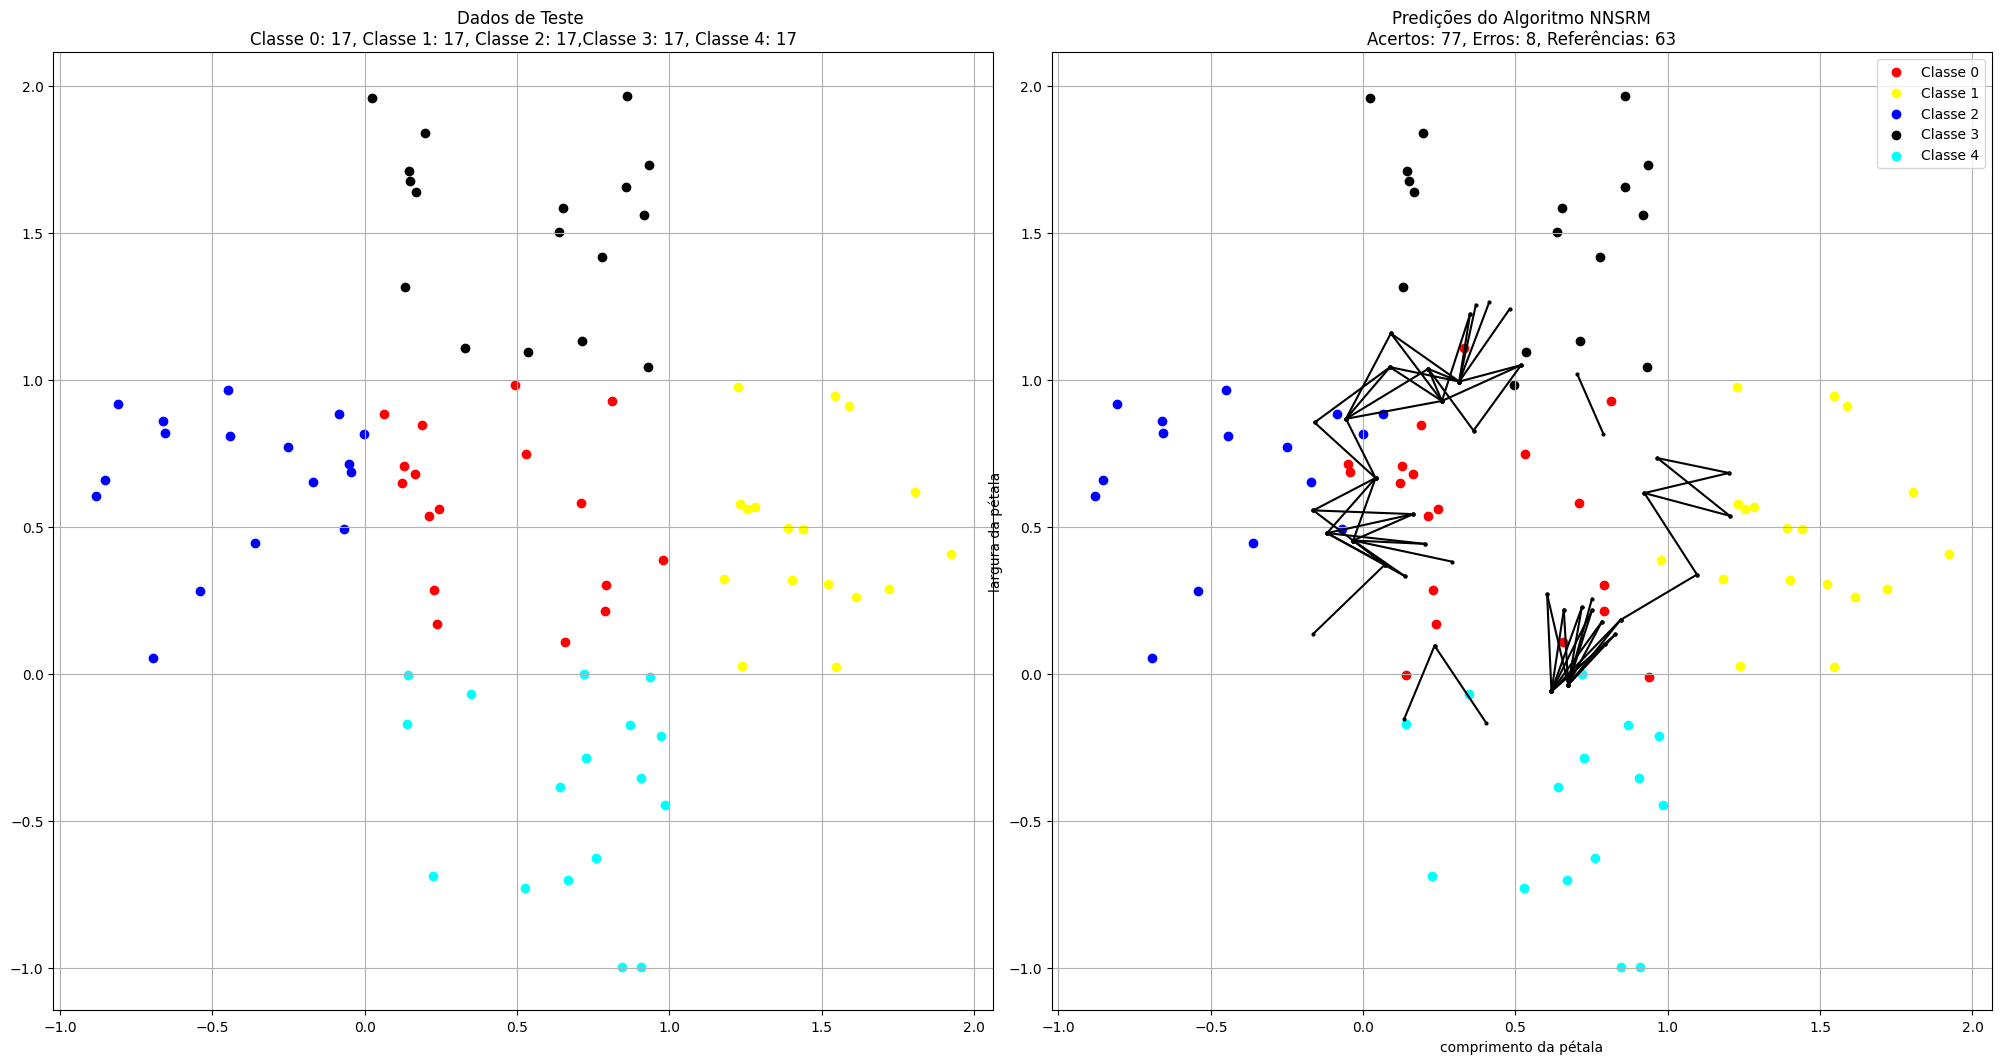

In [ ]:
# Criando o conjunto de treinamento
conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_toy_treino, y_toy_treino)]

# Aplicando o algoritmo NNSRM para múltiplas classes
conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)

# Predizendo os valores com base no conjunto de referências
predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_toy_teste])


num_classe_0 = sum(y_toy_teste == 0)
num_classe_1 = sum(y_toy_teste == 1)
num_classe_2 = sum(y_toy_teste == 2)
num_classe_3 = sum(y_toy_teste == 3)
num_classe_4 = sum(y_toy_teste == 4)

plt.figure(figsize=(100, 100))

# dados de teste
plt.subplot(10,10,1)

plt.title(f"Dados de Teste \nClasse 0: {num_classe_0}, Classe 1: {num_classe_1}, Classe 2: {num_classe_2},Classe 3: {num_classe_3}, Classe 4: {num_classe_4}")
plt.scatter(X_toy_teste[y_toy_teste == 0][:, 0], X_toy_teste[y_toy_teste == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy_teste[y_toy_teste == 1][:, 0], X_toy_teste[y_toy_teste == 1][:, 1], color='yellow', label='Classe 1')
plt.scatter(X_toy_teste[y_toy_teste == 2][:, 0], X_toy_teste[y_toy_teste == 2][:, 1], color='blue', label='Classe 2')
plt.scatter(X_toy_teste[y_toy_teste == 3][:, 0], X_toy_teste[y_toy_teste == 3][:, 1], color='black', label='Classe 3')
plt.scatter(X_toy_teste[y_toy_teste == 4][:, 0], X_toy_teste[y_toy_teste == 4][:, 1], color='cyan', label='Classe 4')
plt.grid(True)

# Subplot 2: Predições
plt.subplot(10,10,2)
acertos = 0
erros = 0
for i, (x, y) in enumerate(X_toy_teste):
    cor = 'black' if y_toy_teste[i] == predicoes[i] else 'red'
    if y_toy_teste[i] == predicoes[i]:
        acertos += 1
    else:
        erros += 1


# Destacar os pontos de referência
for xr1, xr2 in conjunto_referencias:
    plt.plot([xr1[0], xr2[0]], [xr1[1], xr2[1]], 'ko-', markersize=2)

plt.title(f"Predições do Algoritmo NNSRM\nAcertos: {acertos}, Erros: {erros}, Referências: {len(conjunto_referencias)}")

plt.scatter(X_toy_teste[predicoes == 0][:, 0], X_toy_teste[predicoes == 0][:, 1], color='red', label='Classe 0')
plt.scatter(X_toy_teste[predicoes == 1][:, 0], X_toy_teste[predicoes == 1][:, 1], color='yellow', label='Classe 1')
plt.scatter(X_toy_teste[predicoes == 2][:, 0], X_toy_teste[predicoes == 2][:, 1], color='blue', label='Classe 2')
plt.scatter(X_toy_teste[predicoes == 3][:, 0], X_toy_teste[predicoes == 3][:, 1], color='black', label='Classe 3')
plt.scatter(X_toy_teste[predicoes == 4][:, 0], X_toy_teste[predicoes == 4][:, 1], color='cyan', label='Classe 4')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel("comprimento da pétala")
plt.ylabel("largura da pétala")
plt.show()


## DATASET IRIS, existem erros na predição porque foram usadas apenas 2 features de 4 para fazer as predições (ver a última versão no final)

Selecionando apenas length e width (de petalas) das 4 features de IRIS: 
      sepal length  sepal width  petal length  petal width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
..            ...          ...           ...          ...
145           6.7          3.0           5.2          2.3
146           6.3          2.5           5.0          1.9
147           6.5          3.0           5.2          2.0
148           6.2          3.4           5.4          2.3
149           5.9          3.0           5.1          1.8

[150 rows x 4 columns]
Distâncias calculadas entre classes: 867


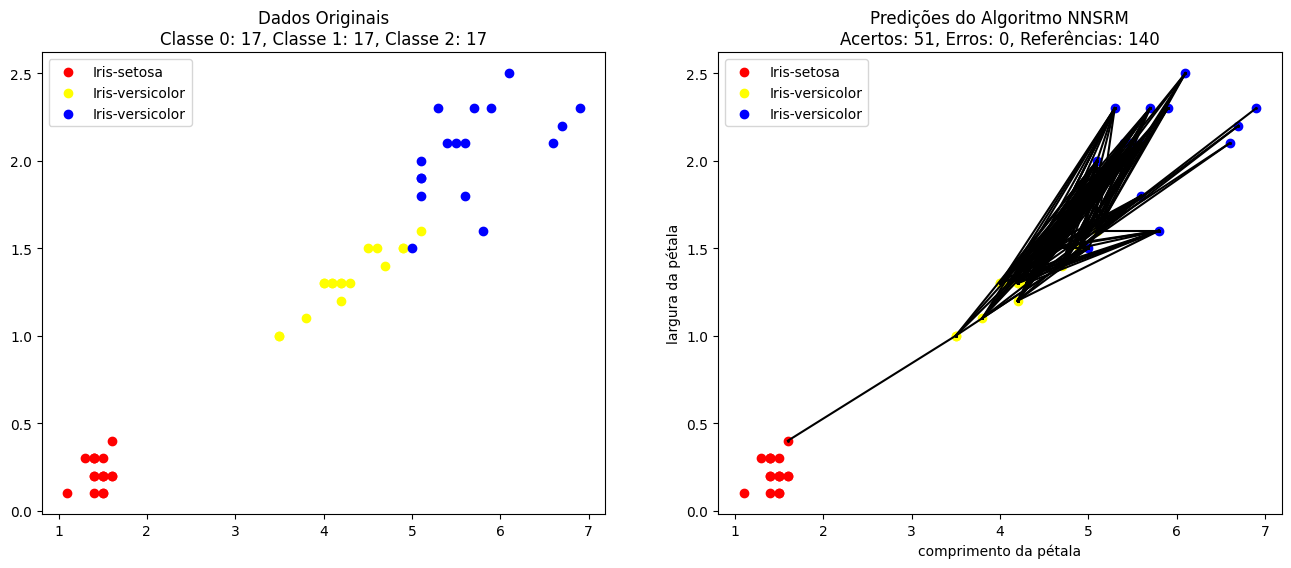

In [ ]:
# rotulos de iris - ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
df_iris = fetch_ucirepo(id=53) # df iris

# features e classes de iris
X_iris_df = df_iris.data.features
y_iris_df = df_iris.data.targets

print("Selecionando apenas length e width (de petalas) das 4 features de IRIS: \n",df_iris.data.features)

# pegando os valores
X_iris = X_iris_df.values  # de df para numpy array - matriz de features (vetor bidimensional)
y_iris = y_iris_df.values.ravel()  # df para numpy array com flat para 1D - vetor de classes

# pegando petal length  petal width - comprimento e largura das petalas (trabalhando com 2 features)
X_iris = X_iris[:, [2,3]]
X_iris2 =X_iris
y_iris2 = y_iris

####################### Reduzindo de 150 pontos (numero de X_iris e y_iris) para agilizar contas:
X_iris_reduzido, _, y_iris_reduzido, _ = train_test_split(
    X_iris, y_iris, stratify=y_iris, test_size=0.66, random_state=42) # reduzindo para 33% de 150 pontos - 50 pontos


X_iris = X_iris_reduzido # 10% dos dados 10% de 150=15 (os erros vão ser bem maiores)
y_iris = y_iris_reduzido # 10% dos dados (os erros vão ser bem maiores)


# conjunto de treinamento
conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_iris, y_iris)]

conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)

# predições os valores com base no conjunto de referências
predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_iris])

plt.figure(figsize=(16, 6))

# Subplot 1: Dados Originais
plt.subplot(1, 2, 1)
# for i, (x, y) in enumerate(X_iris):
#   plt.text(x, y, str(y_iris[i]), fontsize=20, ha='center', va='center')

num_classe_0 = sum(y_iris == classes[0])
num_classe_1 = sum(y_iris == classes[1])
num_classe_2 = sum(y_iris == classes[2])

plt.title(f"Dados Originais\nClasse 0: {num_classe_0}, Classe 1: {num_classe_1}, Classe 2: {num_classe_2}")
red = plt.scatter(X_iris[y_iris == classes[0]][:, 0], X_iris[y_iris == classes[0]][:, 1], color='red')
yellow = plt.scatter(X_iris[y_iris == classes[1]][:, 0], X_iris[y_iris == classes[1]][:, 1], color='yellow')
blue = plt.scatter(X_iris[y_iris == classes[2]][:, 0], X_iris[y_iris == classes[2]][:, 1], color='blue')

plt.legend([red, yellow, blue], [classes[0], classes[1], classes[1]])

plt.subplot(1, 2, 2)
plt.title(f"Predições do Algoritmo NNSRM\nAcertos: {acertos}, Erros: {erros}, Referências: {len(conjunto_referencias)}")

acertos = 0
erros = 0
for i, (x, y) in enumerate(X_iris):
    cor = 'black' if y_iris[i] == predicoes[i] else 'red'
    if y_iris[i] == predicoes[i]:
        acertos += 1
    else:
        erros += 1
    # plt.text(x, y, str(predicoes[i]), fontsize=20, ha='center', va='center', color=cor)

red = plt.scatter(X_iris[predicoes == classes[0]][:, 0], X_iris[predicoes == classes[0]][:, 1], color='red')
yellow = plt.scatter(X_iris[predicoes == classes[1]][:, 0], X_iris[predicoes == classes[1]][:, 1], color='yellow')
blue = plt.scatter(X_iris[predicoes == classes[2]][:, 0], X_iris[predicoes == classes[2]][:, 1], color='blue')

# Destacar os pontos de referência
for xr1, xr2 in conjunto_referencias:
    plt.plot([xr1[0], xr2[0]], [xr1[1], xr2[1]], 'ko-', markersize=1)
plt.xlabel("comprimento da pétala")
plt.ylabel("largura da pétala")
plt.legend([red, yellow, blue], [classes[0], classes[1], classes[1]])

plt.show()
# Deveria ser 100% de chance de acertar dentro do próprio conjunto de treino - 2 features de 4

## Predições para testes (também usando ainda 2 features)

Distâncias calculadas entre classes: 363


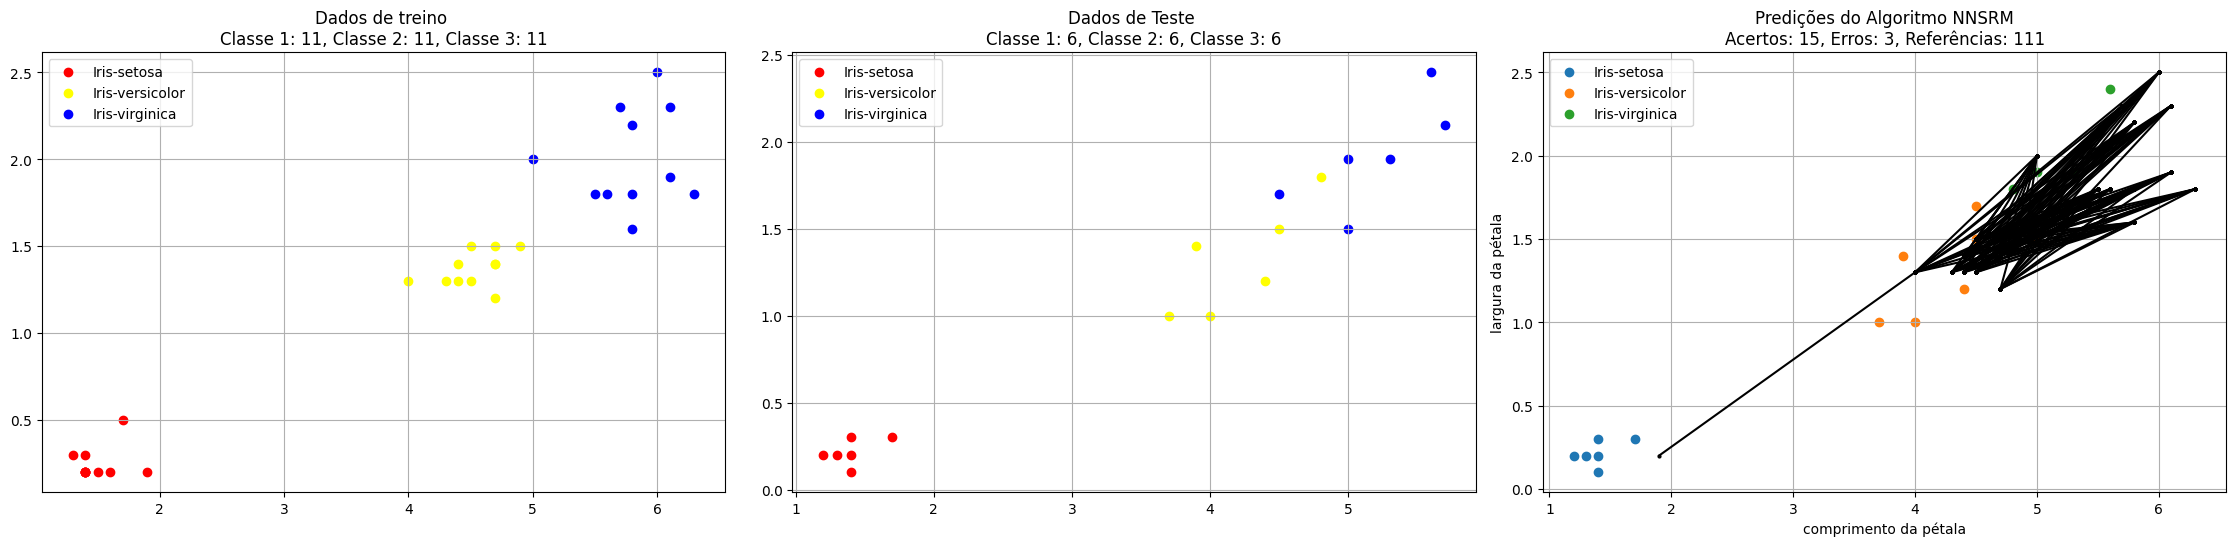

In [ ]:
X_iris_reduzido, _, y_iris_reduzido, _ = train_test_split(
    X_iris2, y_iris2, stratify=y_iris2, test_size=0.66, random_state=20)

X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(
        X_iris_reduzido, y_iris_reduzido, stratify = y_iris_reduzido, train_size=0.66, random_state=30) # 66% para treino

classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_iris_train, y_iris_train)]

# Aplicando o algoritmo NNSRM para múltiplas classes
conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)

# Predizendo os valores com base no conjunto de referências
predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_iris_test])

# plot dos dados de treino
num_classe_0 = sum(y_iris_train == classes[0])
num_classe_1 = sum(y_iris_train == classes[1])
num_classe_2 = sum(y_iris_train == classes[2])

plt.figure(figsize=(75, 50))

plt.subplot(10,10,1)
# for i, (x, y) in enumerate(X_toy_teste):
#   plt.text(x, y, str(y_toy_teste[i]), fontsize=20, ha='center', va='center')

plt.title(f"Dados de treino \nClasse 1: {num_classe_0}, Classe 2: {num_classe_1}, Classe 3: {num_classe_2}")
red = plt.scatter(X_iris_train[y_iris_train == classes[0]][:, 0], X_iris_train[y_iris_train == classes[0]][:, 1], color='red', label=classes[0])
yellow = plt.scatter(X_iris_train[y_iris_train == classes[1]][:, 0], X_iris_train[y_iris_train == classes[1]][:, 1], color='yellow', label=classes[1])
blue = plt.scatter(X_iris_train[y_iris_train == classes[2]][:, 0], X_iris_train[y_iris_train == classes[2]][:, 1], color='blue', label=classes[2])

plt.legend([red, yellow, blue], [classes[0], classes[1], classes[2]])

plt.grid(True)

num_classe_0 = sum(y_iris_test == classes[0])
num_classe_1 = sum(y_iris_test == classes[1])
num_classe_2 = sum(y_iris_test == classes[2])

# dados de teste
plt.subplot(10,10,2)
# for i, (x, y) in enumerate(X_toy_teste):
#   plt.text(x, y, str(y_toy_teste[i]), fontsize=20, ha='center', va='center')

plt.title(f"Dados de Teste \nClasse 1: {num_classe_0}, Classe 2: {num_classe_1}, Classe 3: {num_classe_2}")
red = plt.scatter(X_iris_test[y_iris_test == classes[0]][:, 0], X_iris_test[y_iris_test == classes[0]][:, 1], color='red', label=classes[0])
yellow = plt.scatter(X_iris_test[y_iris_test == classes[1]][:, 0], X_iris_test[y_iris_test == classes[1]][:, 1], color='yellow', label=classes[1])
blue = plt.scatter(X_iris_test[y_iris_test == classes[2]][:, 0], X_iris_test[y_iris_test == classes[2]][:, 1], color='blue', label=classes[2])

plt.legend([red, yellow, blue], [classes[0], classes[1], classes[2]])

plt.grid(True)

#  Predições
plt.subplot(10,10,3)
acertos = 0
erros = 0
for i, (x, y) in enumerate(X_iris_test):
    cor = 'black' if y_iris_test[i] == predicoes[i] else 'red'
    if y_iris_test[i] == predicoes[i]:
        acertos += 1
    else:
        erros += 1
    # plt.text(x, y, str(predicoes[i]), fontsize=20, ha='center', va='center', color=cor)

# Destacar os pontos de referência
for xr1, xr2 in conjunto_referencias:
    plt.plot([xr1[0], xr2[0]], [xr1[1], xr2[1]], 'ko-', markersize=2)

plt.title(f"Predições do Algoritmo NNSRM\nAcertos: {acertos}, Erros: {erros}, Referências: {len(conjunto_referencias)}")
plt.scatter(X_iris_test[predicoes == classes[0]][:, 0], X_iris_test[predicoes == classes[0]][:, 1],  label=classes[0])
plt.scatter(X_iris_test[predicoes == classes[1]][:, 0], X_iris_test[predicoes == classes[1]][:, 1], label=classes[1])
plt.scatter(X_iris_test[predicoes == classes[2]][:, 0], X_iris_test[predicoes == classes[2]][:, 1],  label=classes[2])
plt.legend()

plt.grid(True)
plt.xlabel("comprimento da pétala")
plt.ylabel("largura da pétala")
plt.tight_layout()
plt.show()

Dataset GLASS+IDENTIFICATION (O mesmo - essa versão usa 2 features de 9, portanto deve haver mais erros)

Selecionando apenas Mg e K (Magnésio e Potássio), 2 das 9 (fazendo com que o código atual tenha muitos erros pois trabalha com 2 features) features de GLASS: 
           RI     Na    Mg    Al     Si     K    Ca    Ba   Fe
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0
..       ...    ...   ...   ...    ...   ...   ...   ...  ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0

[214 rows x 9 columns]
Distâncias calculadas entre classes: 645


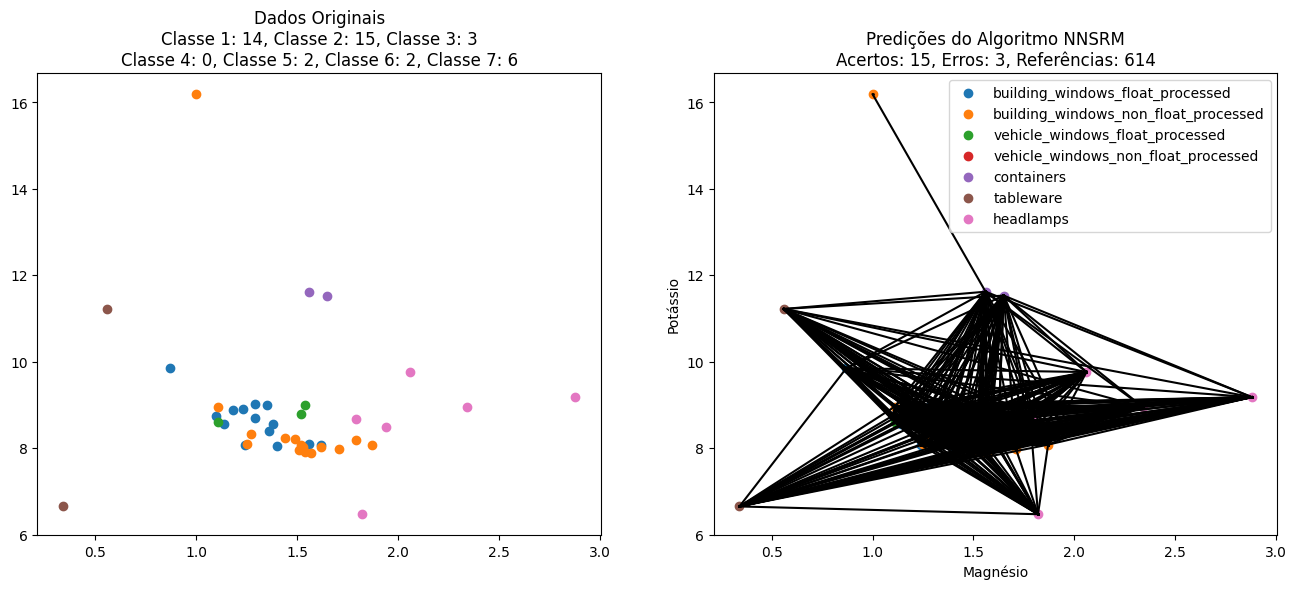

In [ ]:
# rotulos de iris - ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
# rotulos de glass - [1 2 3 5 6 7]
# 1	building_windows_float_processed
# 2	building_windows_non_float_processed
# 3	vehicle_windows_float_processed
# 4	vehicle_windows_non_float_processed (none in this database)
# 5	containers
# 6	tableware
# 7	headlamps

df_glass = fetch_ucirepo(id=42) # dataframe glass identification[
classes = [1,2,3,4,5,6,7]
nomes_classes = ["building_windows_float_processed","building_windows_non_float_processed","vehicle_windows_float_processed",
                 "vehicle_windows_non_float_processed","containers","tableware","headlamps"]
df_iris = df_glass # passando para variavel df iris para economizar reescrita

# features e classes de iris
X_iris_df = df_iris.data.features
y_iris_df = df_iris.data.targets

print("Selecionando apenas Mg e K (Magnésio e Potássio), 2 das 9 (fazendo com que o código atual tenha muitos erros pois trabalha com 2 features) features de GLASS: \n",df_iris.data.features)

# pegando os valores
X_iris = X_iris_df.values  # de df para numpy array - matriz de features (vetor bidimensional)
y_iris = y_iris_df.values.ravel()  # df para numpy array com flat para 1D - vetor de classes

# pegando Magnésio Mg e K potássio (trabalhando com 2 features de 9 - minoria)
X_glass = X_iris[:, [3,6]]

X_iris = X_glass
X_iris2 =X_iris
y_iris2 = y_iris

####################### Reduzindo de 150 pontos (numero de X_iris e y_iris) para agilizar contas:
X_iris_reduzido, _, y_iris_reduzido, _ = train_test_split(
    X_iris, y_iris, stratify=y_iris, test_size=0.8, random_state=42)  # usando apenas 20%  +- 42 pontos


X_iris = X_iris_reduzido # 10% dos dados 10% de 150=15 (os erros vão ser bem maiores)
y_iris = y_iris_reduzido # 10% dos dados (os erros vão ser bem maiores)


# Criando o conjunto de treinamento
conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_iris, y_iris)]

# Aplicando o algoritmo NNSRM para múltiplas classes
conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)

# Predizendo os valores com base no conjunto de referências
predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_iris])

# Plotando os dados originais e as predições
plt.figure(figsize=(16, 6))

# Subplot 1: Dados Originais
plt.subplot(1, 2, 1)
# for i, (x, y) in enumerate(X_iris):
#   plt.text(x, y, str(y_iris[i]), fontsize=20, ha='center', va='center')

num_classe_0 = sum(y_iris == classes[0])
num_classe_1 = sum(y_iris == classes[1])
num_classe_2 = sum(y_iris == classes[2])
num_classe_3 = sum(y_iris == classes[3])
num_classe_4 = sum(y_iris == classes[4])
num_classe_5 = sum(y_iris == classes[5])
num_classe_6 = sum(y_iris == classes[6])

plt.title(f"Dados Originais\nClasse 1: {num_classe_0}, Classe 2: {num_classe_1}, Classe 3: {num_classe_2}\nClasse 4: {num_classe_3}, Classe 5: {num_classe_4}, Classe 6: {num_classe_5}, Classe 7: {num_classe_6}")
dado1 = plt.scatter(X_iris[y_iris == classes[0]][:, 0], X_iris[y_iris == classes[0]][:, 1])
dado2 = plt.scatter(X_iris[y_iris == classes[1]][:, 0], X_iris[y_iris == classes[1]][:, 1])
dado3 = plt.scatter(X_iris[y_iris == classes[2]][:, 0], X_iris[y_iris == classes[2]][:, 1])
dado4 = plt.scatter(X_iris[y_iris == classes[3]][:, 0], X_iris[y_iris == classes[3]][:, 1])
dado5 = plt.scatter(X_iris[y_iris == classes[4]][:, 0], X_iris[y_iris == classes[4]][:, 1])
dado6 = plt.scatter(X_iris[y_iris == classes[5]][:, 0], X_iris[y_iris == classes[5]][:, 1])
dado7 = plt.scatter(X_iris[y_iris == classes[6]][:, 0], X_iris[y_iris == classes[6]][:, 1])

plt.subplot(1, 2, 2)
plt.title(f"Predições do Algoritmo NNSRM\nAcertos: {acertos}, Erros: {erros}, Referências: {len(conjunto_referencias)}")

acertos = 0
erros = 0
for i, (x, y) in enumerate(X_iris):
    cor = 'black' if y_iris[i] == predicoes[i] else 'red'
    if y_iris[i] == predicoes[i]:
        acertos += 1
    else:
        erros += 1
    # plt.text(x, y, str(predicoes[i]), fontsize=20, ha='center', va='center', color=cor)

dado1 = plt.scatter(X_iris[predicoes == classes[0]][:, 0], X_iris[predicoes == classes[0]][:, 1],label = nomes_classes[0])
dado2 = plt.scatter(X_iris[predicoes == classes[1]][:, 0], X_iris[predicoes == classes[1]][:, 1],label = nomes_classes[1])
dado3 = plt.scatter(X_iris[predicoes == classes[2]][:, 0], X_iris[predicoes == classes[2]][:, 1],label = nomes_classes[2])
dado4 = plt.scatter(X_iris[predicoes == classes[3]][:, 0], X_iris[predicoes == classes[3]][:, 1],label = nomes_classes[3])
dado5 = plt.scatter(X_iris[predicoes == classes[4]][:, 0], X_iris[predicoes == classes[4]][:, 1],label = nomes_classes[4])
dado6 = plt.scatter(X_iris[predicoes == classes[5]][:, 0], X_iris[predicoes == classes[5]][:, 1],label = nomes_classes[5])
dado7 = plt.scatter(X_iris[predicoes == classes[6]][:, 0], X_iris[predicoes == classes[6]][:, 1],label = nomes_classes[6])


# Destacar os pontos de referência
for xr1, xr2 in conjunto_referencias:
    plt.plot([xr1[0], xr2[0]], [xr1[1], xr2[1]], 'ko-', markersize=1)
plt.xlabel("Magnésio")
plt.ylabel("Potássio")
plt.legend()

plt.show()
# Deveria ser 100% de chance de acertar dentro do próprio conjunto de treino - 2 features de 9

Distâncias calculadas entre classes: 263


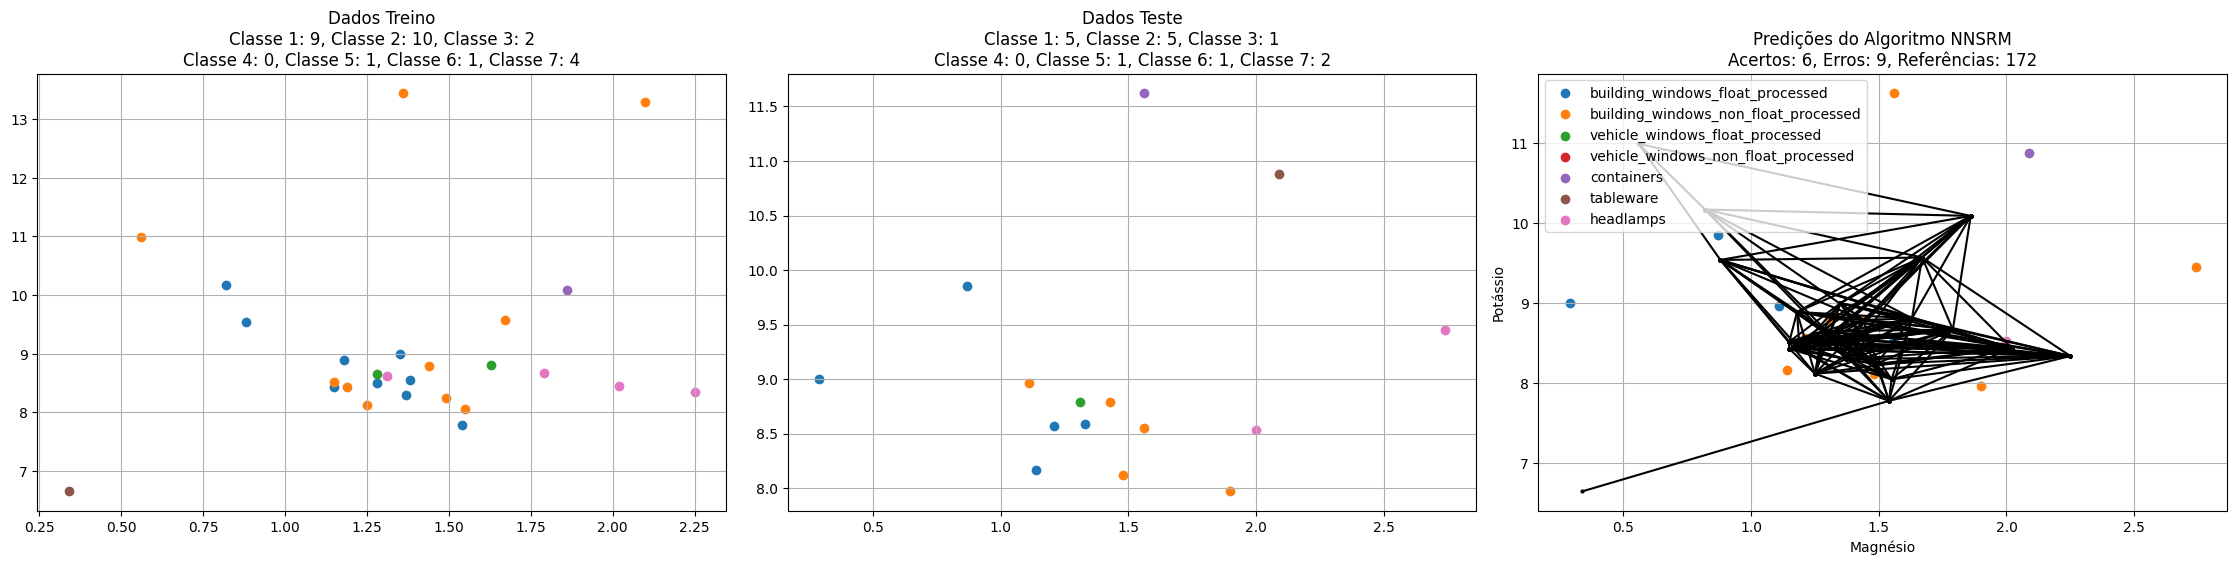

In [ ]:
X_iris_reduzido, _, y_iris_reduzido, _ = train_test_split(
    X_iris2, y_iris2, stratify=y_iris2, test_size=0.8, random_state=14) # usando apenas 20%  +- 42 pontos

X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(
        X_iris_reduzido, y_iris_reduzido, stratify = y_iris_reduzido, train_size=0.66, random_state=30) # 66% dos dados como treino (dos 10% obtidos antes, ou seja 10 pontos de treino e 5 de teste)

conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_iris_train, y_iris_train)]

# Aplicando o algoritmo NNSRM para múltiplas classes
conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)

# Predizendo os valores com base no conjunto de referências
predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_iris_test])

# plot dos dados de treino
num_classe_0 = sum(y_iris_train == classes[0])
num_classe_1 = sum(y_iris_train == classes[1])
num_classe_2 = sum(y_iris_train == classes[2])
num_classe_3 = sum(y_iris_train == classes[3])
num_classe_4 = sum(y_iris_train == classes[4])
num_classe_5 = sum(y_iris_train == classes[5])
num_classe_6 = sum(y_iris_train == classes[6])

plt.figure(figsize=(75, 50))

plt.subplot(10,10,1)
# for i, (x, y) in enumerate(X_toy_teste):
#   plt.text(x, y, str(y_toy_teste[i]), fontsize=20, ha='center', va='center')

plt.title(f"Dados Treino\nClasse 1: {num_classe_0}, Classe 2: {num_classe_1}, Classe 3: {num_classe_2}\nClasse 4: {num_classe_3}, Classe 5: {num_classe_4}, Classe 6: {num_classe_5}, Classe 7: {num_classe_6}")
dado1 = plt.scatter(X_iris_train[y_iris_train == classes[0]][:, 0], X_iris_train[y_iris_train == classes[0]][:, 1])
dado2 = plt.scatter(X_iris_train[y_iris_train == classes[1]][:, 0], X_iris_train[y_iris_train == classes[1]][:, 1])
dado3 = plt.scatter(X_iris_train[y_iris_train == classes[2]][:, 0], X_iris_train[y_iris_train == classes[2]][:, 1])
dado4 = plt.scatter(X_iris_train[y_iris_train == classes[3]][:, 0], X_iris_train[y_iris_train == classes[3]][:, 1])
dado5 = plt.scatter(X_iris_train[y_iris_train == classes[4]][:, 0], X_iris_train[y_iris_train == classes[4]][:, 1])
dado6 = plt.scatter(X_iris_train[y_iris_train == classes[5]][:, 0], X_iris_train[y_iris_train == classes[5]][:, 1])
dado7 = plt.scatter(X_iris_train[y_iris_train == classes[6]][:, 0], X_iris_train[y_iris_train == classes[6]][:, 1])

plt.grid(True)

num_classe_0 = sum(y_iris_test == classes[0])
num_classe_1 = sum(y_iris_test == classes[1])
num_classe_2 = sum(y_iris_test == classes[2])
num_classe_3 = sum(y_iris_test == classes[3])
num_classe_4 = sum(y_iris_test == classes[4])
num_classe_5 = sum(y_iris_test == classes[5])
num_classe_6 = sum(y_iris_test == classes[6])

# dados de teste
plt.subplot(10,10,2)
# for i, (x, y) in enumerate(X_toy_teste):
#   plt.text(x, y, str(y_toy_teste[i]), fontsize=20, ha='center', va='center')

plt.title(f"Dados Teste\nClasse 1: {num_classe_0}, Classe 2: {num_classe_1}, Classe 3: {num_classe_2}\nClasse 4: {num_classe_3}, Classe 5: {num_classe_4}, Classe 6: {num_classe_5}, Classe 7: {num_classe_6}")
dado1 = plt.scatter(X_iris_test[y_iris_test == classes[0]][:, 0], X_iris_test[y_iris_test == classes[0]][:, 1])
dado2 = plt.scatter(X_iris_test[y_iris_test == classes[1]][:, 0], X_iris_test[y_iris_test == classes[1]][:, 1])
dado3 = plt.scatter(X_iris_test[y_iris_test == classes[2]][:, 0], X_iris_test[y_iris_test == classes[2]][:, 1])
dado4 = plt.scatter(X_iris_test[y_iris_test == classes[3]][:, 0], X_iris_test[y_iris_test == classes[3]][:, 1])
dado5 = plt.scatter(X_iris_test[y_iris_test == classes[4]][:, 0], X_iris_test[y_iris_test == classes[4]][:, 1])
dado6 = plt.scatter(X_iris_test[y_iris_test == classes[5]][:, 0], X_iris_test[y_iris_test == classes[5]][:, 1])
dado7 = plt.scatter(X_iris_test[y_iris_test == classes[6]][:, 0], X_iris_test[y_iris_test == classes[6]][:, 1])

plt.grid(True)

#  Predições
plt.subplot(10,10,3)
acertos = 0
erros = 0
for i, (x, y) in enumerate(X_iris_test):
    cor = 'black' if y_iris_test[i] == predicoes[i] else 'red'
    if y_iris_test[i] == predicoes[i]:
        acertos += 1
    else:
        erros += 1
    # plt.text(x, y, str(predicoes[i]), fontsize=20, ha='center', va='center', color=cor)

# Destacar os pontos de referência
for xr1, xr2 in conjunto_referencias:
    plt.plot([xr1[0], xr2[0]], [xr1[1], xr2[1]], 'ko-', markersize=2)

plt.title(f"Predições do Algoritmo NNSRM\nAcertos: {acertos}, Erros: {erros}, Referências: {len(conjunto_referencias)}")
plt.scatter(X_iris_test[predicoes == classes[0]][:, 0], X_iris_test[predicoes == classes[0]][:, 1],  label=nomes_classes[0])
plt.scatter(X_iris_test[predicoes == classes[1]][:, 0], X_iris_test[predicoes == classes[1]][:, 1],  label=nomes_classes[1])
plt.scatter(X_iris_test[predicoes == classes[2]][:, 0], X_iris_test[predicoes == classes[2]][:, 1],  label=nomes_classes[2])
plt.scatter(X_iris_test[predicoes == classes[3]][:, 0], X_iris_test[predicoes == classes[3]][:, 1],  label=nomes_classes[3])
plt.scatter(X_iris_test[predicoes == classes[4]][:, 0], X_iris_test[predicoes == classes[4]][:, 1],  label=nomes_classes[4])
plt.scatter(X_iris_test[predicoes == classes[5]][:, 0], X_iris_test[predicoes == classes[5]][:, 1],  label=nomes_classes[5])
plt.scatter(X_iris_test[predicoes == classes[6]][:, 0], X_iris_test[predicoes == classes[6]][:, 1],  label=nomes_classes[6])

plt.legend()
plt.xlabel("Magnésio")
plt.ylabel("Potássio")
plt.grid(True)
plt.tight_layout()
plt.show()

## Usando múltiplas features para detectar múltiplas classes em IRIS

Selecionando todas as features de IRIS: comprimento e largura da sépaala e da pétala
      sepal length  sepal width  petal length  petal width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
..            ...          ...           ...          ...
145           6.7          3.0           5.2          2.3
146           6.3          2.5           5.0          1.9
147           6.5          3.0           5.2          2.0
148           6.2          3.4           5.4          2.3
149           5.9          3.0           5.1          1.8

[150 rows x 4 columns]
Distâncias calculadas entre classes: 867
acertos:  51
{((6.5, 2.8, 4.6, 1.5), (7.2, 3.6, 6.1, 2.5)), ((5.5, 2.5, 4.0, 1.3), (6.0, 2.2, 5.0, 1.5)), ((6.4, 2.9, 4.3, 1.3), (6.8, 3.2, 5.9, 2.3)), (

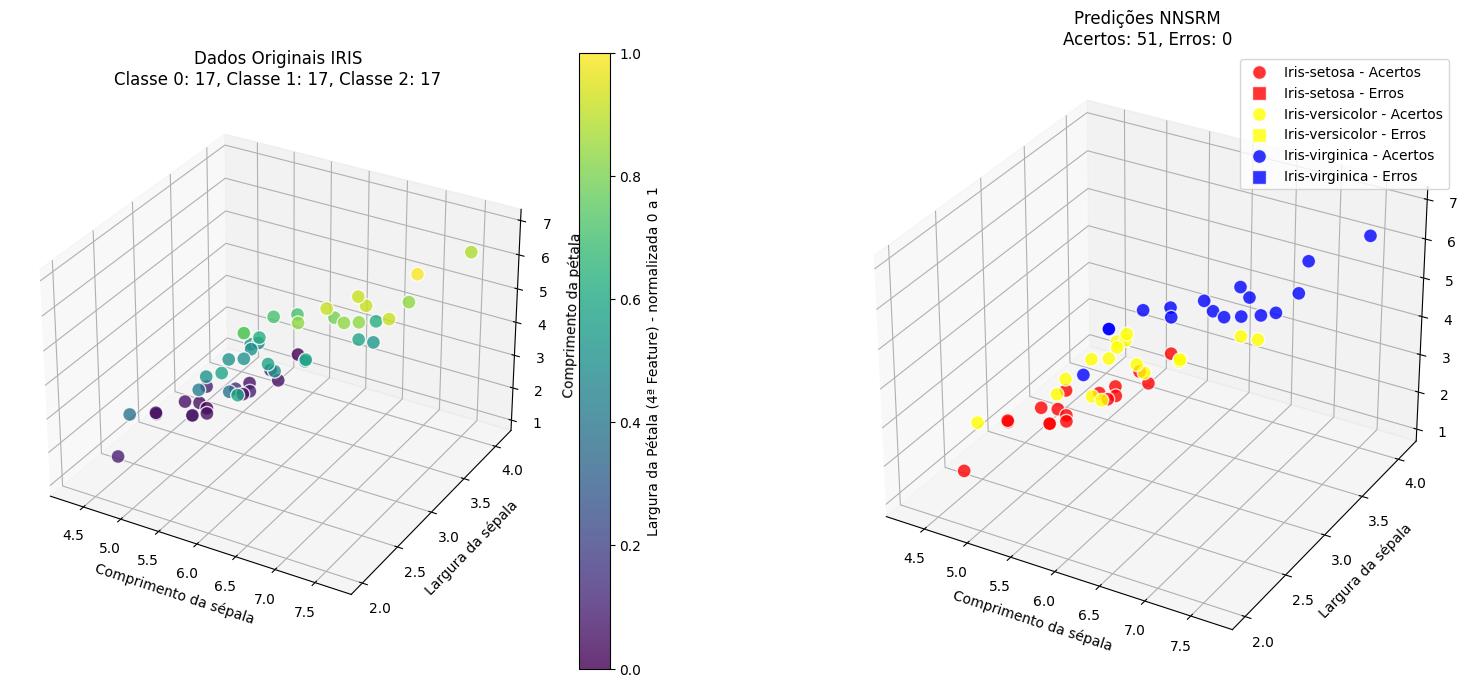

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# rotulos de iris - ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
df_iris = fetch_ucirepo(id=53) # df iris

# features e classes de iris
X_iris_df = df_iris.data.features
y_iris_df = df_iris.data.targets

print("Selecionando todas as features de IRIS: comprimento e largura da sépaala e da pétala\n",df_iris.data.features)

# pegando os valores
X_iris = X_iris_df.values  # de df para numpy array - matriz de features (vetor bidimensional)
y_iris = y_iris_df.values.ravel()  # df para numpy array com flat para 1D - vetor de classes

####################### Reduzindo de 150 pontos (numero de X_iris e y_iris) para agilizar contas:
X_iris_reduzido, _, y_iris_reduzido, _ = train_test_split(
    X_iris, y_iris, stratify=y_iris, test_size=0.66, random_state=42)


X_iris = X_iris_reduzido # 10% dos dados 10% de 150=15 (os erros vão ser bem maiores)
y_iris = y_iris_reduzido # 10% dos dados (os erros vão ser bem maiores)


# Criando o conjunto de treinamento
conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_iris, y_iris)]

# Aplicando o algoritmo NNSRM para múltiplas classes
conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)

# Predizendo os valores com base no conjunto de referências
predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_iris])

acertos = sum(y_iris == predicoes)
erros = len(y_iris) - acertos
print("acertos: ",acertos)

fig = plt.figure(figsize=(19, 8))

ax = fig.add_subplot(121, projection='3d')
ax.set_title(f'Dados Originais IRIS\nClasse 0: {sum(y_iris == classes[0])}, Classe 1: {sum(y_iris == classes[1])}, Classe 2: {sum(y_iris == classes[2])}')

norm = plt.Normalize(X_iris[:, 3].min(), X_iris[:, 3].max())
cmap = plt.get_cmap("viridis")

# Plotando os dados originais em 3D
sc = ax.scatter(X_iris[:, 0], X_iris[:, 1], X_iris[:, 2], c=cmap(norm(X_iris[:, 3])), s=100, alpha=0.8, edgecolor='w')

ax.set_xlabel('Comprimento da sépala')
ax.set_ylabel('Largura da sépala')
ax.set_zlabel('Comprimento da pétala')
# Adicionando a barra de cores
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Largura da Pétala (4ª Feature) - normalizada 0 a 1')

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title(f'Predições NNSRM\nAcertos: {acertos}, Erros: {erros}')

colors = ['red','yellow','blue']
for i, label in enumerate(classes):
    idx_acertos = np.where((predicoes == label) & (y_iris == label))
    idx_erros = np.where((predicoes == label) & (y_iris != label))

    # Plotando acertos
    ax2.scatter(X_iris[idx_acertos, 0], X_iris[idx_acertos, 1], X_iris[idx_acertos, 2],
                c=colors[i], label=f'{label} - Acertos', s=100, alpha=0.8, edgecolor='w', marker='o')

    # Plotando erros
    ax2.scatter(X_iris[idx_erros, 0], X_iris[idx_erros, 1], X_iris[idx_erros, 2],
                c=colors[i], label=f'{label} - Erros', s=100, alpha=0.8, edgecolor='w', marker='s')


ax2.set_xlabel('Comprimento da sépala')
ax2.set_ylabel('Largura da sépala')
ax2.set_zlabel('Comprimento da pétala')
ax2.legend(loc='best')

print(conjunto_referencias)


plt.show()

Distâncias calculadas entre classes: 363
acertos:  16
{((6.5, 3.2, 5.1, 2.0), (6.9, 3.1, 4.9, 1.5)), ((6.5, 2.8, 4.6, 1.5), (7.2, 3.6, 6.1, 2.5)), ((7.0, 3.2, 4.7, 1.4), (7.6, 3.0, 6.6, 2.1)), ((5.8, 2.7, 5.1, 1.9), (6.5, 2.8, 4.6, 1.5)), ((6.4, 2.8, 5.6, 2.1), (6.4, 2.9, 4.3, 1.3)), ((5.7, 3.0, 4.2, 1.2), (5.9, 3.0, 5.1, 1.8)), ((5.6, 2.7, 4.2, 1.3), (6.3, 2.9, 5.6, 1.8)), ((5.6, 2.7, 4.2, 1.3), (6.4, 2.8, 5.6, 2.1)), ((5.7, 2.8, 4.1, 1.3), (5.9, 3.0, 5.1, 1.8)), ((5.8, 2.7, 5.1, 1.9), (6.9, 3.1, 4.9, 1.5)), ((5.6, 2.7, 4.2, 1.3), (5.8, 2.7, 5.1, 1.9)), ((6.3, 2.5, 4.9, 1.5), (6.8, 3.0, 5.5, 2.1)), ((5.5, 2.4, 3.8, 1.1), (6.3, 2.9, 5.6, 1.8)), ((5.5, 2.4, 3.8, 1.1), (6.4, 2.8, 5.6, 2.1)), ((6.3, 2.5, 4.9, 1.5), (6.4, 3.2, 5.3, 2.3)), ((6.4, 3.2, 5.3, 2.3), (7.0, 3.2, 4.7, 1.4)), ((5.9, 3.0, 5.1, 1.8), (6.9, 3.1, 4.9, 1.5)), ((5.9, 3.0, 5.1, 1.8), (6.5, 2.8, 4.6, 1.5)), ((6.4, 2.8, 5.6, 2.1), (7.0, 3.2, 4.7, 1.4)), ((6.3, 2.9, 5.6, 1.8), (6.4, 2.9, 4.3, 1.3)), ((5.0, 2.0, 3.5, 1.0), (5

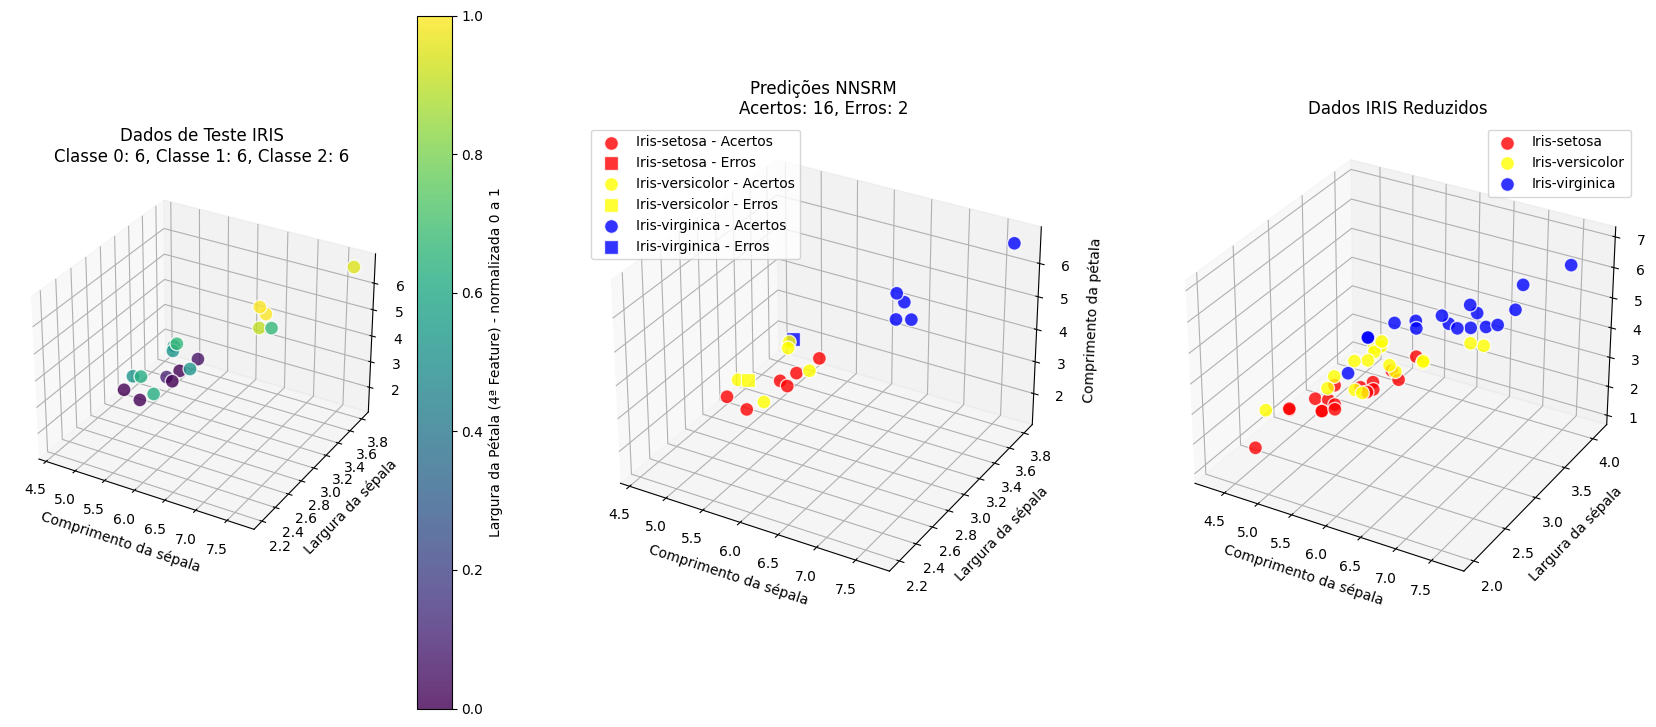

In [ ]:
X_iris = X_iris_df.values
y_iris = y_iris_df.values.ravel()

X_iris_reduzido, _, y_iris_reduzido, _ = train_test_split(
    X_iris, y_iris, stratify=y_iris, test_size=0.66, random_state=42)

X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(
        X_iris_reduzido, y_iris_reduzido, stratify = y_iris_reduzido, train_size=0.66, random_state=30) # 66% dos dados como treino (dos 10% obtidos antes, ou seja 10 pontos de treino e 5 de teste)

classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_iris_train, y_iris_train)]

# Aplicando o algoritmo NNSRM para múltiplas classes
conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)

# Predizendo os valores com base no conjunto de referências
predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_iris_test])

acertos = sum(y_iris_test == predicoes)
erros = len(y_iris_test) - acertos
print("acertos: ",acertos)

###################################### 3D ########
colors = ['red','yellow','blue']

fig = plt.figure(figsize=(21, 9))

ax = fig.add_subplot(131, projection='3d')
ax.set_title(f'Dados de Teste IRIS\nClasse 0: {sum(y_iris_test == classes[0])}, Classe 1: {sum(y_iris_test == classes[1])}, Classe 2: {sum(y_iris_test == classes[2])}')

norm = plt.Normalize(X_iris_test[:, 3].min(), X_iris_test[:, 3].max())
cmap = plt.get_cmap("viridis")

# Plotando os dados de teste em 3D
sc = ax.scatter(X_iris_test[:, 0], X_iris_test[:, 1], X_iris_test[:, 2], c=cmap(norm(X_iris_test[:, 3])), s=100, alpha=0.8, edgecolor='w')

ax.set_xlabel('Comprimento da sépala')
ax.set_ylabel('Largura da sépala')
ax.set_zlabel('Comprimento da pétala')
# Adicionando a barra de cores
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Largura da Pétala (4ª Feature) - normalizada 0 a 1')

ax2 = fig.add_subplot(132, projection='3d')
ax2.set_title(f'Predições NNSRM\nAcertos: {acertos}, Erros: {erros}')


for i, label in enumerate(classes):
    idx_acertos = np.where((predicoes == label) & (y_iris_test == label))
    idx_erros = np.where((predicoes == label) & (y_iris_test != label))

    # Plotando acertos
    ax2.scatter(X_iris_test[idx_acertos, 0], X_iris_test[idx_acertos, 1], X_iris_test[idx_acertos, 2],
                c=colors[i], label=f'{label} - Acertos', s=100, alpha=0.8, edgecolor='w', marker='o')

    # Plotando erros
    ax2.scatter(X_iris_test[idx_erros, 0], X_iris_test[idx_erros, 1], X_iris_test[idx_erros, 2],
                c=colors[i], label=f'{label} - Erros', s=100, alpha=0.8, edgecolor='w', marker='s')


ax2.set_xlabel('Comprimento da sépala')
ax2.set_ylabel('Largura da sépala')
ax2.set_zlabel('Comprimento da pétala')
ax2.legend(loc='best')

ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title('Dados IRIS Reduzidos')

for i, label in enumerate(classes):
    idx = np.where(y_iris_reduzido == label)
    ax3.scatter(X_iris_reduzido[idx, 0], X_iris_reduzido[idx, 1], X_iris_reduzido[idx, 2],
                c=colors[i], label=label, s=100, alpha=0.8, edgecolor='w')

ax3.set_xlabel('Comprimento da sépala')
ax3.set_ylabel('Largura da sépala')
ax3.set_zlabel('Comprimento da pétala')
ax3.legend(loc='best')

print(conjunto_referencias)

plt.show()

## multiplas features e multiplas classes - GLASS

Distâncias calculadas entre classes: 105
conjunto_referencias:  {((1.51625, 13.36, 3.58, 1.49, 72.72, 0.45, 8.21, 0.0, 0.0), (1.52101, 13.64, 4.49, 1.1, 71.78, 0.06, 8.75, 0.0, 0.0)), ((1.51742, 13.27, 3.62, 1.24, 73.08, 0.55, 8.07, 0.0, 0.0), (1.52151, 11.03, 1.71, 1.56, 73.44, 0.58, 11.62, 0.0, 0.0)), ((1.51848, 13.64, 3.87, 1.27, 71.96, 0.54, 8.32, 0.0, 0.32), (1.52151, 11.03, 1.71, 1.56, 73.44, 0.58, 11.62, 0.0, 0.0)), ((1.51651, 14.38, 0.0, 1.94, 73.61, 0.0, 8.48, 1.57, 0.0), (1.51911, 13.9, 3.73, 1.18, 72.12, 0.06, 8.89, 0.0, 0.0)), ((1.51651, 14.38, 0.0, 1.94, 73.61, 0.0, 8.48, 1.57, 0.0), (1.51848, 13.64, 3.87, 1.27, 71.96, 0.54, 8.32, 0.0, 0.32)), ((1.51778, 13.21, 2.81, 1.29, 72.98, 0.51, 9.02, 0.0, 0.09), (1.51848, 13.64, 3.87, 1.27, 71.96, 0.54, 8.32, 0.0, 0.32)), ((1.51969, 14.56, 0.0, 0.56, 73.48, 0.0, 11.22, 0.0, 0.0), (1.52101, 13.64, 4.49, 1.1, 71.78, 0.06, 8.75, 0.0, 0.0)), ((1.52101, 13.64, 4.49, 1.1, 71.78, 0.06, 8.75, 0.0, 0.0), (1.52151, 11.03, 1.71, 1.56, 73.44, 

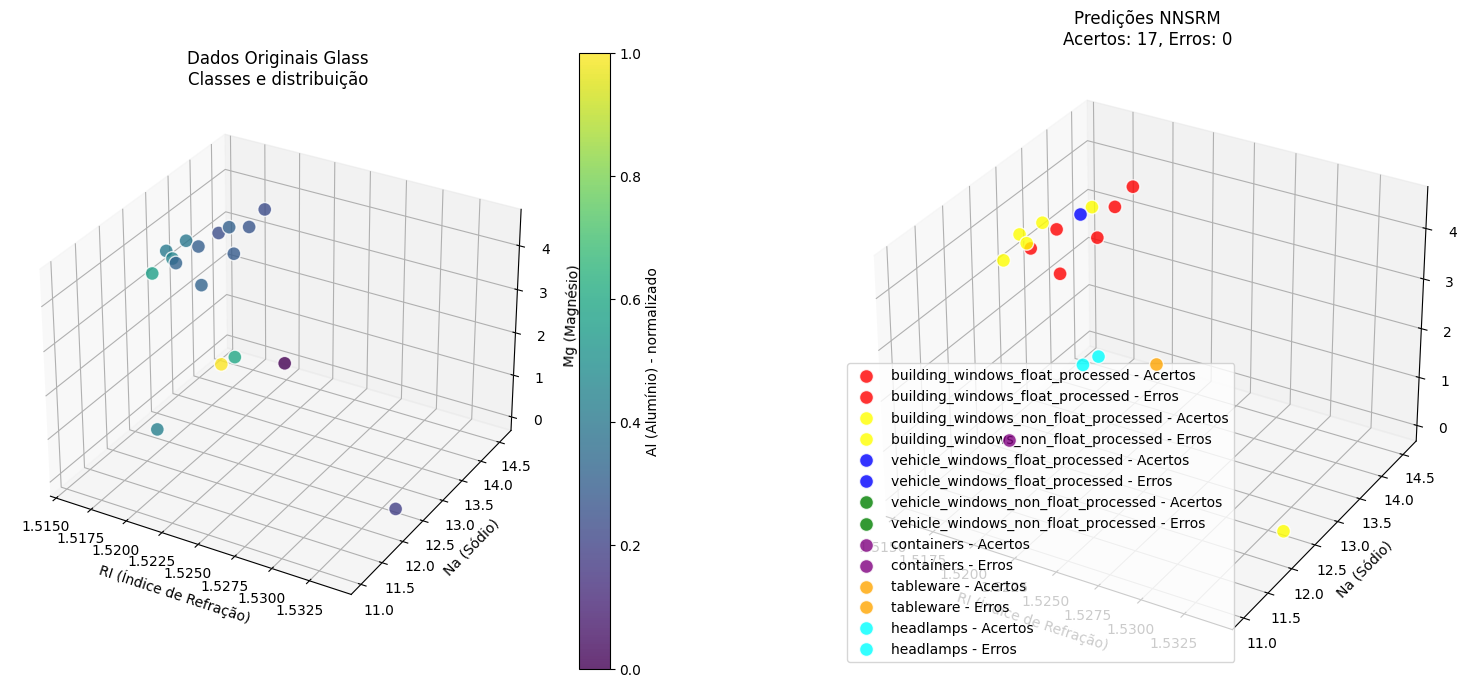

In [ ]:
df_glass =  fetch_ucirepo(id=42)
X_glass_df = df_glass.data.features
y_glass_df = df_glass.data.targets


classes = ["building_windows_float_processed", "building_windows_non_float_processed",
                 "vehicle_windows_float_processed", "vehicle_windows_non_float_processed",
                 "containers", "tableware", "headlamps"]

X_glass = X_glass_df.values
y_glass = y_glass_df.values.ravel()

X_glass_reduzido, _, y_glass_reduzido, _ = train_test_split(
    X_glass, y_glass, stratify=y_glass, test_size=0.92, random_state=42)

X_glass = X_glass_reduzido
y_glass = y_glass_reduzido

conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_glass, y_glass)]

conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)
print("conjunto_referencias: ", conjunto_referencias)


predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_glass])
print(len(X_glass))
print(len(y_glass))
print(len(predicoes))
# Calculando acertos e erros
acertos = sum(y_glass == predicoes)
erros = len(y_glass) - acertos
print("Acertos: ", acertos)

# Plotando os gráficos
fig = plt.figure(figsize=(19, 8))

# Gráfico 3D dos dados originais
ax = fig.add_subplot(121, projection='3d')
ax.set_title(f'Dados Originais Glass\nClasses e distribuição')

norm = plt.Normalize(X_glass[:, 3].min(), X_glass[:, 3].max())
cmap = plt.get_cmap("viridis")

# Plotando os dados originais em 3D
sc = ax.scatter(X_glass[:, 0], X_glass[:, 1], X_glass[:, 2], c=cmap(norm(X_glass[:, 3])), s=100, alpha=0.8, edgecolor='w')

ax.set_xlabel('RI (Índice de Refração)')
ax.set_ylabel('Na (Sódio)')
ax.set_zlabel('Mg (Magnésio)')

# Adicionando a barra de cores
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Al (Alumínio) - normalizado')

# Gráfico 3D das predições do NNSRM
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title(f'Predições NNSRM\nAcertos: {acertos}, Erros: {erros}')

# Usando cores distintas para cada classe
colors = ['red', 'yellow', 'blue', 'green', 'purple', 'orange', 'cyan']
for i, label in enumerate(classes):
    idx_acertos = np.where((predicoes == i+1) & (y_glass == i+1))
    idx_erros = np.where((predicoes == i+1) & (y_glass != i+1))

    # Plotando acertos
    ax2.scatter(X_glass[idx_acertos, 0], X_glass[idx_acertos, 1], X_glass[idx_acertos, 2],
                c=colors[i], label=f'{classes[i]} - Acertos', s=100, alpha=0.8, edgecolor='w')

    # Plotando erros
    ax2.scatter(X_glass[idx_erros, 0], X_glass[idx_erros, 1], X_glass[idx_erros, 2],
                c=colors[i], label=f'{classes[i]} - Erros', s=100, alpha=0.8, edgecolor='w')

ax2.set_xlabel('RI (Índice de Refração)')
ax2.set_ylabel('Na (Sódio)')
ax2.set_zlabel('Mg (Magnésio)')
ax2.legend(loc='best')

# Exibindo as referências utilizadas pelo NNSRM
print(conjunto_referencias)

plt.show()


Distâncias calculadas entre classes: 815
acertos:  16
{((1.51571, 12.72, 3.46, 1.56, 73.2, 0.67, 8.09, 0.0, 0.24), (1.51905, 14.0, 2.39, 1.56, 72.37, 0.0, 9.57, 0.0, 0.0)), ((1.51545, 14.14, 0.0, 2.68, 73.39, 0.08, 9.07, 0.61, 0.05), (1.51735, 13.02, 3.54, 1.69, 72.73, 0.54, 8.44, 0.0, 0.07)), ((1.51299, 14.4, 1.74, 1.54, 74.55, 0.0, 7.59, 0.0, 0.0), (1.51789, 13.19, 3.9, 1.3, 72.33, 0.55, 8.44, 0.0, 0.28)), ((1.51905, 14.0, 2.39, 1.56, 72.37, 0.0, 9.57, 0.0, 0.0), (1.51926, 13.2, 3.33, 1.28, 72.36, 0.6, 9.14, 0.0, 0.11)), ((1.51832, 13.33, 3.34, 1.54, 72.14, 0.56, 8.99, 0.0, 0.0), (1.52213, 14.21, 3.82, 0.47, 71.77, 0.11, 9.57, 0.0, 0.0)), ((1.51783, 12.69, 3.54, 1.34, 72.95, 0.57, 8.75, 0.0, 0.0), (1.52058, 12.85, 1.61, 2.17, 72.18, 0.76, 9.7, 0.24, 0.51)), ((1.51569, 13.24, 3.49, 1.47, 73.25, 0.38, 8.03, 0.0, 0.0), (1.51905, 13.6, 3.62, 1.11, 72.64, 0.14, 8.76, 0.0, 0.0)), ((1.5221, 13.73, 3.84, 0.72, 71.76, 0.17, 9.74, 0.0, 0.0), (1.52725, 13.8, 3.15, 0.66, 70.57, 0.08, 11.64, 0.0,

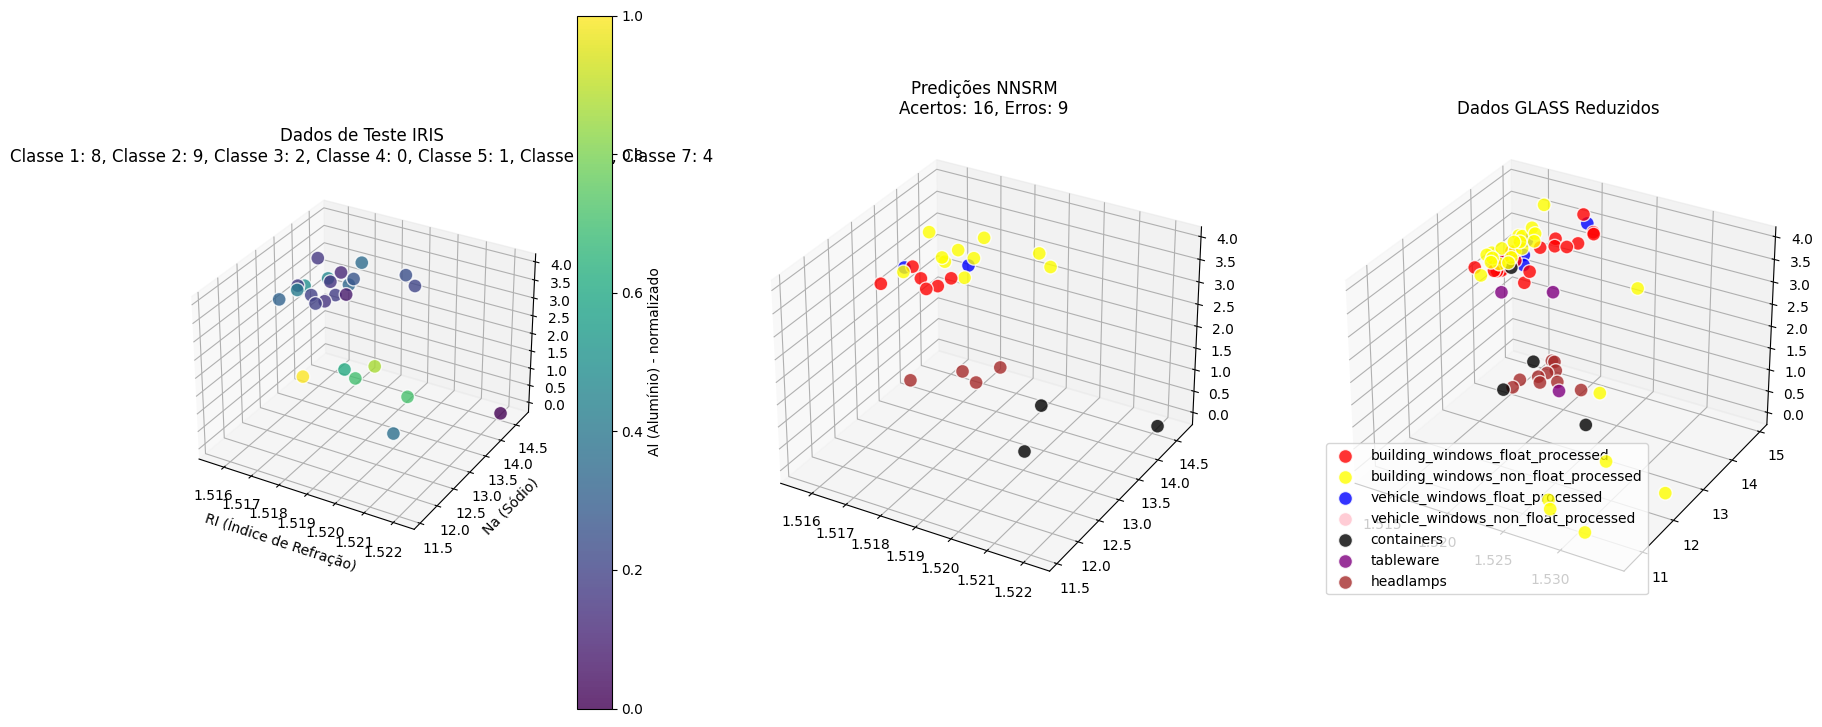

In [ ]:
X_iris = X_glass_df.values
y_iris = y_glass_df.values.ravel()

X_iris_reduzido, _, y_iris_reduzido, _ = train_test_split(
    X_iris, y_iris, stratify=y_iris, test_size=0.66, random_state=30)

X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(
        X_iris_reduzido, y_iris_reduzido, stratify = y_iris_reduzido, train_size=0.66, random_state=30) # 66% dos dados como treino (dos 10% obtidos antes, ou seja 10 pontos de treino e 5 de teste)

classes = ["building_windows_float_processed", "building_windows_non_float_processed",
                 "vehicle_windows_float_processed", "vehicle_windows_non_float_processed",
                 "containers", "tableware", "headlamps"]

conjunto_treinamento = [(xi, yi) for xi, yi in zip(X_iris_train, y_iris_train)]

# Aplicando o algoritmo NNSRM para múltiplas classes
conjunto_referencias = nn_srm_multiclasse(conjunto_treinamento)

# Predizendo os valores com base no conjunto de referências
predicoes = np.array([classificar_com_referencias_multiclasse(xi, conjunto_referencias, conjunto_treinamento,{}) for xi in X_iris_test])

acertos = sum(y_iris_test == predicoes)
erros = len(y_iris_test) - acertos
print("acertos: ",acertos)

###################################### 3D ########
colors = ['red','yellow','blue', 'pink','black','purple', 'brown']

fig = plt.figure(figsize=(21, 9))

ax = fig.add_subplot(131, projection='3d')
ax.set_title(f'Dados de Teste IRIS\nClasse 1: {sum(y_iris_test == 1)}, Classe 2: {sum(y_iris_test == 2)}, Classe 3: {sum(y_iris_test == 3)}, Classe 4: {sum(y_iris_test == 4)}, Classe 5: {sum(y_iris_test == 5)}, Classe 6: {sum(y_iris_test == 6)}, Classe 7: {sum(y_iris_test == 7)}')

norm = plt.Normalize(X_iris_test[:, 3].min(), X_iris_test[:, 3].max())
cmap = plt.get_cmap("viridis") # tipo de mapeamento de cor

# Plotando os dados de teste em 3D
sc = ax.scatter(X_iris_test[:, 0], X_iris_test[:, 1], X_iris_test[:, 2], c=cmap(norm(X_iris_test[:, 3])), s=100, alpha=0.8, edgecolor='w')

ax.set_xlabel('RI (Índice de Refração)')
ax.set_ylabel('Na (Sódio)')
ax.set_zlabel('Mg (Magnésio)')

# Adicionando a barra de cores
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Al (Alumínio) - normalizado')

ax2 = fig.add_subplot(132, projection='3d')
ax2.set_title(f'Predições NNSRM\nAcertos: {acertos}, Erros: {erros}')


for i, label in enumerate(classes):
    idx_acertos = np.where((predicoes == i+1) & (y_iris_test == i+1))
    idx_erros = np.where((predicoes == i+1) & (y_iris_test != i+1))

    # Plotando acertos
    ax2.scatter(X_iris_test[idx_acertos, 0], X_iris_test[idx_acertos, 1], X_iris_test[idx_acertos, 2],
                c=colors[i], label=f'{label} - Acertos', s=100, alpha=0.8, edgecolor='w')

    # Plotando erros
    ax2.scatter(X_iris_test[idx_erros, 0], X_iris_test[idx_erros, 1], X_iris_test[idx_erros, 2],
                c=colors[i], label=f'{label} - Erros', s=100, alpha=0.8, edgecolor='w')


ax.set_xlabel('RI (Índice de Refração)')
ax.set_ylabel('Na (Sódio)')
ax.set_zlabel('Mg (Magnésio)')
# ax2.legend(loc='best')

ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title('Dados GLASS Reduzidos')

for i, label in enumerate(classes):
    idx = np.where(y_iris_reduzido == i+1)
    ax3.scatter(X_iris_reduzido[idx, 0], X_iris_reduzido[idx, 1], X_iris_reduzido[idx, 2],
                c=colors[i], label=label, s=100, alpha=0.8, edgecolor='w')

ax.set_xlabel('RI (Índice de Refração)')
ax.set_ylabel('Na (Sódio)')
ax.set_zlabel('Mg (Magnésio)')
ax3.legend(loc='best')

print(conjunto_referencias)

plt.show()